# Lab 4: Recurrent models

This lab represents the practice with embeddings (word vectors, in this case) and recurrent neural models in NLP. The first part focuses on embeddings as input to a recurrent model, and the second part focuses on contextual embeddings derived from transformer models, applying them to the task of word sense disambiguation following the approach from the original paper by [Peters et al. (2018)](https://aclanthology.org/N18-1202.pdf)

# Rules
* The assignment should submitted to **Blackboard** as `.ipynb`. Only **one submission per group**.

* The **filename** should be the group number, e.g., `01.ipynb` or `31.ipynb`.

* The questions marked **Extra** or **Optional** are an additional challenge for those interested in going the extra mile. There are no points for them.

**Rules for implementation**

* You should **write your code and answers in this iPython Notebook**. (See http://ipython.org/notebook.html for reference material.) If you have problems, please contact your teaching assistant.

* Use only **one cell for code** and **one cell for markdown** answers!    

    * Put all code in the cell with the `## YOUR CODE HERE ##` comment.
    * Provide brief comments on what the code does at crucial points.
    * For theoretical questions, put your solution in the `█████ YOUR ANSWER HERE █████` cell and keep the header.

* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `#TEST...` or edit their code cells.
* Don't change the names of provided functions and variables or arguments of the functions.
* Leave the output of your code in the output cells.
* **Don't output unnecessary info** (e.g., printing variables for debugging purposes) or **add extra code cells** (e.g., for mounting your google drive). This clutters the notebook and slows down the grading.
* Test your code and **make sure we can run your notebook** in the colab environment.
* Don't forget to fill in the contribution information.

<font color="red">You following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>  

# <font color="red">Contributions</font>

~~Delete this text and write instead of it your:~~
* ~~a list of group members names (NOT student IDs)~~
* ~~who contributed to which exercises (you don't need to be very detailed)~~

# General instructions

Before diving into the exercises, keep in mind that the variables defined previously can be reused in the subsequent cells. So there is no need to redefine the same variable in multiple sections, e.g., it is sufficient to read the file in a variable once and later reuse the value of the variable, instead of re-reading the file.   

If your code is too long and using several code cells instead of a single code cell. Rethink how to organize data in variables that you can easily access required info. Reading about [list comprehension](https://realpython.com/list-comprehension-python/#leverage-list-comprehensions) can be useful.

Your code will often be evaluated based on its behaviour. So, during the grading some code cells are executed. If code runtime is too long than expected, this will hinder grading.

<font color="red">**The cases similar to the above-mentioned ones, will be subject to penalty points.**</font>

<font color="red">**Pay attention to test units**</font> that are either provided as assert cases or as comments. Test units help you by giving you a hint about a correct answer. Note that **passing test units doesn't guarantee the full points** for an execise because test units are incomplete and the code might fail on other test units.

# Part 1: POS tagging with LSTM

In the first part of lab 4, we will play with training a recurrent model for part of speech tagging. We start with implementing the evaluation and training procedures for LSTM-based tagger. Initially we will work on the toy data so that you understand the procedures. Later we use the Brown corpus with Universal POS tags. We will train a tagger on the data and analyse the training dynamics. Then we will use pre-trained word embeddings to initialize an LSTM. We will experiment with training taggers with and without pre-trained word vectors.

## Setup

In [ ]:
import random, math
import nltk
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tqdm import tqdm

# if any cell errors with "A UTF-8 locale is required. Got ANSI_X3.4-1968"
# uncomment and run the next two lines
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
# torch-specific code
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
torchtext.disable_torchtext_deprecation_warning()

In [ ]:
print(f"NLTK version: {nltk.__version__}")
print(f"torch version: {torch.__version__}")

NLTK version: 3.8.1
torch version: 2.3.0+cu121


In [ ]:
# download several data incorporated in NLTK
nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('semcor')
nltk.download('wordnet')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package semcor to /root/nltk_data...
[nltk_data]   Package semcor is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Some auxiliary functions that will be reused throughout the notebook

def plot_numbers(num_listm, xlabel="Epochs", ylabel="Loss", label=None):
    """ Visualizes a list of numbers as a line plot
    """
    plt.plot(np.arange(len(num_listm)), num_listm, 'o-', markersize=2, label=label)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if label: plt.legend()

# Let's plot the loss values and see how training on more epochs decreases the loss value
def plot_results(res, parts=("train", "valid"), metrics=("loss", "acc"), title=None):
    """ Shorthand for contrasting loss and accuracy numbers obtained on different datasets
    """
    for m in metrics:
        for p in parts:
            plot_numbers(res[p][m], label=f"{p} {m}", ylabel=m)
        if title: plt.title(title)
        plt.show()

def train_validation_split(sequence, train_ratio, valid_ratio, seed=0, seperate_tags=False):
    """ returns two non-overlapping subpart of the input sequence.
        The sizes of the parts satisfy the size ration constraint.
        If seperate_tags is on, this means the input has format of [(w1,pos1), (w2,pos2)]
        and it will be converted to [(w1,w2), (pos1,pos2)]
    """
    assert train_ratio + valid_ratio <= 1
    population = list(sequence)
    n = len(population)
    train_num, valid_num = math.floor(n * train_ratio), math.floor(n * valid_ratio)
    random.seed(seed)
    data = random.sample(population, train_num + valid_num)
    if seperate_tags:
        data = [ list(zip(*sent)) for sent in data ]
    return data[:train_num], data[train_num:]

## LSTM tagger

Read the [pytorch tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) on sequence tagging with LSTM. It is very important that you practice how to read and understand the tutorials on web. Not all tutorials are written in a clear way, and understanding the overlooked parts requires practice and effort.
Fortunately, the aforementioned tutorial is very well written. Though it uses many new operations related to tensors (=a multi-dimensional matrix containing elements of a single data type).

Pytorch is well documented and almost any function, method, or class can be looked up [here](https://pytorch.org/docs/stable/index.html), in the top-left corner. For example, `torch.randn` is defined [here](https://pytorch.org/docs/stable/generated/torch.randn.html#torch.randn). Note that keywords in the code of the tutorial are hyperlinks with links to the corresponding documentation.

The code below is copied from the tutorial page as we will reuse certain variables and functions. We only renamed the data variable name to indicate that it is toy data.

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


toy_training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in toy_training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}  # Assign each tag with a unique index

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


The code below is also copied from the tutorial but it incorporates two additions:

1.   Fixing the torch's random generator seeds: see `nn_seed` and `em_seed`. These seeds control the initialization of `self.word_embeddings` from [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding) and `self.lstm` from [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM). In the first case, the `vocab_size` number of `embedding_dim`-dimensional tensors are generated, while in the second case the LSTM network is initialized with random weights (note that `self.hidden2tag` is also randomized weights denoting `V` matrix, from J&M chapter 9, that is used to obtain output from the hidden layer for each time step). We make the LSTM initialization based on the seed to maintain replicability of the same results.

2.   Making the class flexible to allow initialization from pre-trained word embeddings. `embedding` input can be a tuple that specifies the dimensions of the embedding layer or a ready tensor that records pre-trained word embeddings.

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding, hidden_dim, tagset_size, nn_seed=0, em_seed=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        if isinstance(embedding, torch.Tensor):
            self.word_embeddings = nn.Embedding.from_pretrained(embedding)
            embedding_dim = self.word_embeddings.weight.size(1)
        else:
            torch.manual_seed(em_seed)
            vocab_size, embedding_dim = embedding
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        torch.manual_seed(nn_seed)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## Ex1.1a [7pt] Evaluation

The training (i.e. last) code in the [tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#example-an-lstm-for-part-of-speech-tagging) contains lines of code that we will reuse several times. That's why we are going to make specific functions out of them. The first function we will make takes a model and data (and other stuff) and returns predictions and metrics wrapped in a dictionary. read the function definition carefully for more details.

In [ ]:
def prepare_sequence(seq, to_ix):
    """
    seq - input that will be transformed.
    to_ix - either w2i or t2i to transform words to indices or POS tags to indices.
    return:
      the tensor that can be used in the LSTM as the input in the foward method or the target to compute the loss/accuracy.
    """

    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


def get_real_tags(tag_scores, to_ix):
  """
  tag_scores - received tensor.
  to-ix - dictionary that will be used to obtain the real tag.
  return:
    real tags from a prediction.
  """
  max_prob = torch.argmax(tag_scores, dim=1)
  pred_tags = []
  for i in max_prob:
    pred_i = [key for key, value in to_ix.items() if i == to_ix[key]]
    pred_tags.append(pred_i[0])
  return pred_tags


def evaluate_tagger(model, data, w2i=None, t2i=None, get_tags=False, get_scores=False):
    """ model - an NN model, in particular an LSTMTagger object
        data - a sequence of pairs of a list of tokens and a list of POS tags
        w2i - a dict mapping words to indices, when w2i is not specified this means that
            tokens are already mapped to indices in data and no mapping is needed. This option
            will be handy when evaluating a tagger several times on a data during the training.
        t2i - a dict mapping POS tags to indices. When t2i is not specified this means that
            pos tags are already mapped to indices in data, and also when returning tags
            as an output, they won't be mapped to human readable tags, but instead returned
            as indices.
        get_tags - whether return predicted tags (i.e., most probable tag per token)
        get_scores - whether to return actual tag scores for each token
    return:
        a dictionary with keys 'loss', 'acc', 'scores', 'tags'.
        Note that the loss value is averaged across sentences: (loss_sen_1+...loss_sen_N)/N.
        The keys are present in the dictionary for certain values according to the input.
        For example, if get_tags=False, there shouldn't be 'tags' key in the dictionary.
        As an example, see the reference output below.
    """
    ### YOUR CODE HERE ###
    dictionary = {"loss": None, "acc": None, "tags": None, "scores": None}

    loss_function = nn.NLLLoss()
    acc_loss, correct_predictions = 0, 0
    all_tag_scores = []
    all_real_tags = []
    with torch.no_grad(): # don't train
      for sentence, tags in data:

        sentence_in = prepare_sequence(sentence, w2i) if w2i is not None else sentence
        targets = prepare_sequence(tags, t2i) if t2i is not None else tags

        tag_scores = model(sentence_in)

        pred_tags = get_real_tags(tag_scores, t2i)
        corrects = sum(p == t for p, t in zip(pred_tags, tags))
        correct_predictions += corrects
        loss = loss_function(tag_scores, targets)
        acc_loss += loss.item()

        all_real_tags.append(pred_tags)
        all_tag_scores.append(tag_scores)


      avg_loss = acc_loss / len(data)
      accuracy = correct_predictions / sum(len(i) for i,_ in data)
      dictionary["loss"] = avg_loss
      dictionary["acc"] = accuracy
      dictionary["scores"] = all_tag_scores if get_tags == True else dictionary.pop("scores")
      dictionary["tags"] = all_real_tags if get_tags == True else dictionary.pop("tags")


      return dictionary




In [ ]:
# TEST Ex1.1
# deterministically initialize LSTM tagger and predict the tags for the data
toy_tagger = LSTMTagger((len(word_to_ix), EMBEDDING_DIM), HIDDEN_DIM, len(tag_to_ix))
# evaluate tagger
pred = evaluate_tagger(toy_tagger, toy_training_data, w2i=word_to_ix, t2i=tag_to_ix, get_tags=True, get_scores=True)
print(pred)

print("Tokens, gold tags, and predicetd most probable tag per token")
for (sent, tags1), tags2 in zip(toy_training_data, pred['tags']):
    for seq in (sent, tags1, tags2):
        print(''.join([ f"{el:^8}" for el in seq ]))


{'loss': 1.0800790786743164, 'acc': 0.5555555555555556, 'tags': [['NN', 'NN', 'DET', 'NN', 'NN'], ['NN', 'DET', 'DET', 'NN']], 'scores': [tensor([[-1.0546, -1.0076, -1.2498],
        [-1.0310, -1.0182, -1.2656],
        [-0.9870, -1.0311, -1.3069],
        [-1.1044, -0.9940, -1.2090],
        [-1.0882, -0.9960, -1.2248]]), tensor([[-1.0523, -0.9922, -1.2727],
        [-0.9906, -0.9994, -1.3451],
        [-0.9478, -1.0155, -1.3856],
        [-1.0980, -0.9716, -1.2449]])]}
Tokens, gold tags, and predicetd most probable tag per token
  The     dog     ate     the    apple  
  DET      NN      V      DET      NN   
   NN      NN     DET      NN      NN   
Everybody  read    that    book  
   NN      V      DET      NN   
   NN     DET     DET      NN   


Reference output:

```
{'loss': 1.0800790786743164, 'acc': 0.5555555555555556, 'tags': [['NN', 'NN', 'DET', 'NN', 'NN'], ['NN', 'DET', 'DET', 'NN']], 'scores': [tensor([[-1.0546, -1.0076, -1.2498],
        [-1.0310, -1.0182, -1.2656],
        [-0.9870, -1.0311, -1.3069],
        [-1.1044, -0.9940, -1.2090],
        [-1.0882, -0.9960, -1.2248]]), tensor([[-1.0523, -0.9922, -1.2727],
        [-0.9906, -0.9994, -1.3451],
        [-0.9478, -1.0155, -1.3856],
        [-1.0980, -0.9716, -1.2449]])]}
Tokens, gold tags, and predicetd most probable tag per token
  The     dog     ate     the    apple
  DET      NN      V      DET      NN
   NN      NN     DET      NN      NN
Everybody  read    that    book
   NN      V      DET      NN
   NN     DET     DET      NN
```

## Q1.1b [3pt] Explain predictions



1.   *Given the above predictions from the tagger, is there any rationale for why the tagger predicts NN often?*
2.   *What is the predicted probability distribution over the tags for "that" in the data*? In case your tagger's output is different from the reference output, make clear which output your answer is based on.



<font color="red">█████ YOUR ANSWER HERE █████</font>
1. It could be because 4/9 words are NN in the training data while 3 are DET and just 2 are V. This can affect the prediction because NN is the majority tag in the training data.
2. The predicted probability distribution over the tags for that is:[-0.9478, -1.0155, -1.3856]. (It's the same as the reference output).

## Ex1.2: [8pt] Training

We need to write a function that trains a model on the data. This function later will be reused for training the tagger on different training sets. Again, reuse the code from the tutorial page to complete the body of the function. *Keep the learning rate same*. During training the training data is isually shuffled, but here, for simplicity, *don't shuffle the data*, keep it as it is.
Note that the function has to return the list of loss and accuracy values that is one item longer than the number of epochs.
Don't forget to **reuse** `evaluate_tagger` function.
Read the function definition for more details.

**Hints**: the function presupposes training and evaluating a model on the same data several times. Make sure that you convert the data into tensors once and not for every epoch.
Feel free to define sub-functions that will be reused for train and valid parts. This will make the code less redundant.
The tqdm module gives a nice way to report the progress of training.

In [ ]:
def train_tagger(model, train, w2i, t2i,
                 valid=None, epoch_num=10, verbose=False):
    """ model - an NN model, in particular an LSTMTagger object
        train - a sequence of pairs of a list of tokens and a list of POS tags
        w2i - a dict mapping words to indices
        t2i - a dict mapping POS tags to indices
        valid - optional validation data structurally identical to train.
            When the validation data is provided, the output also records results about it.
        epoch_num - the number of times to train the model on the train data
        verbose - a flag that makes the function print various useful info. For example,
            it can be used to turn on/off the tqdm progress bar during the training.

        return:
            a dictionary with keys 'train' and 'valid', the existence of the latter depends
            on whether the valid arg is provided. The values of the keys are dictionaries
            with keys 'loss', 'acc', 'best_acc'. The first two have a list value of length epoch_num + 1.
            This is because it includes the loss & acc of the initial model and the final too.
            Note that the loss value should be averaged across sentences: (loss_sen_1+...loss_sen_N)/N.
            'best_acc' keeps the max values from the 'acc' list.
            See the reference output below as an example.
    """
    ### YOUR CODE HERE ###

    dictionary = {"train": {}, "valid": {}}
    best_acc = 0
    losses, acc = [], []
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    # before training:
    preds = evaluate_tagger(model, train, w2i=w2i, t2i=t2i, get_tags=False, get_scores=False)
    losses.append(preds["loss"])
    acc.append(preds["acc"])

    val_losses, val_acc = [],[]
    best_acc_val = 0
    for epoch in range(epoch_num):
      acc_loss, correct_predictions = 0, 0

      for sentence, tags in tqdm(train, desc=f'Epoch {epoch + 1}/{epoch_num}', disable = not verbose):
        model.zero_grad() # clear out gradients
        sentence_in = prepare_sequence(sentence, w2i) if w2i is not None else sentence
        targets = prepare_sequence(tags, t2i) if t2i is not None else tags

        tag_scores = model(sentence_in)

        pred_tags = get_real_tags(tag_scores, t2i)
        corrects = sum(p == t for p, t in zip(pred_tags, tags))
        correct_predictions += corrects
        loss = loss_function(tag_scores, targets)
        acc_loss += loss.item()

        loss.backward() # backward propagation
        optimizer.step()

      avg_loss = acc_loss / len(train)
      accuracy = correct_predictions / sum(len(i) for i,_ in train)
      best_acc = accuracy if accuracy > best_acc else best_acc
      acc.append(accuracy)
      losses.append(avg_loss)
      if verbose == True:
        print(f'Epoch {epoch + 1}/{epoch_num}: Avg Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}')

      # For validation

      if valid:
        preds = evaluate_tagger(model, valid, w2i=w2i, t2i=t2i, get_tags=False, get_scores=False)
        val_losses.append(preds["loss"])
        val_acc.append(preds["acc"])
        best_acc_val = preds["acc"] if preds["acc"] > best_acc_val else best_acc_val

    dictionary["train"]["loss"] = losses
    dictionary["train"]["acc"] = acc
    dictionary["train"]["best_acc"] = best_acc

    if valid:
      dictionary["valid"]["loss"] = val_losses
      dictionary["valid"]["acc"] = val_acc
      dictionary["valid"]["best_acc"] = best_acc

    return dictionary





In [ ]:
# TEST Ex1.2-1
# defining a toy validation set
toy_validation_data = [
    ("The dog read that book".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody ate the apple".split(), ["NN", "V", "DET", "NN"])
]
# initialize the model
trained_toy_tagger = LSTMTagger((len(word_to_ix), EMBEDDING_DIM), HIDDEN_DIM, len(tag_to_ix))
# train and retrieve the loss values per epoch
res = train_tagger(trained_toy_tagger, toy_training_data, word_to_ix, tag_to_ix, valid=toy_validation_data, epoch_num=200, verbose=False)
print(f"results: {res}")

results: {'train': {'loss': [1.0800790786743164, 1.0801255702972412, 1.0763735175132751, 1.072936773300171, 1.0697717666625977, 1.0668398141860962, 1.064107894897461, 1.0615471601486206, 1.0591323375701904, 1.0568419694900513, 1.0546568632125854, 1.0525607466697693, 1.0505394339561462, 1.048580288887024, 1.0466725826263428, 1.044806718826294, 1.0429743528366089, 1.0411682724952698, 1.0393816232681274, 1.0376091003417969, 1.0358451008796692, 1.034085214138031, 1.032325267791748, 1.0305613279342651, 1.0287899374961853, 1.0270078778266907, 1.0252123475074768, 1.0234004259109497, 1.021569311618805, 1.0197166502475739, 1.017840176820755, 1.0159374177455902, 1.0140063166618347, 1.01204451918602, 1.0100499987602234, 1.008020669221878, 1.0059542655944824, 1.0038489401340485, 1.0017026662826538, 0.9995130896568298, 0.9972783029079437, 0.9949962496757507, 0.9926645755767822, 0.9902814030647278, 0.9878444671630859, 0.9853514432907104, 0.9828000664710999, 0.980188250541687, 0.9775134325027466, 0.9

Reference output
```
results: {'train': {'loss': [1.0800790786743164, 1.0762487053871155, 1.072744369506836, 1.069520890712738, 1.0665384531021118, 1.0637630820274353, 1.0611646175384521, 1.0587173104286194, 1.0563986897468567, 1.0541892051696777, 1.052071988582611, 1.0500323176383972, 1.048057198524475, 1.0461354851722717, 1.0442574620246887, 1.0424144864082336, 1.0405990481376648, 1.0388041734695435, 1.0370243191719055, 1.0352540016174316, 1.0334884524345398, 1.0317234992980957, 1.029955267906189, 1.0281798839569092, 1.0263945162296295, 1.0245959758758545, 1.0227813720703125, 1.0209480822086334, 1.0190935730934143, 1.0172154307365417, 1.0153114199638367, 1.0133792757987976, 1.0114167928695679, 1.0094218254089355, 1.0073922872543335, 1.0053260326385498, 1.0032211244106293, 1.0010755360126495, 0.9988869428634644, 0.9966534376144409, 0.9943730235099792, 0.9920433461666107, 0.9896624088287354, 0.9872280955314636, 0.9847381114959717, 0.9821900725364685, 0.9795820713043213, 0.9769113957881927, 0.9741758704185486, 0.971373051404953, 0.968500405550003, 0.9655555188655853, 0.9625357389450073, 0.9594384133815765, 0.9562608897686005, 0.9530004262924194, 0.9496542811393738, 0.9462195336818695, 0.9426933825016022, 0.9390727579593658, 0.9353549182415009, 0.9315365552902222, 0.9276146292686462, 0.9235861897468567, 0.9194479286670685, 0.9151966571807861, 0.9108293950557709, 0.9063427448272705, 0.9017335474491119, 0.8969985246658325, 0.8921345770359039, 0.8871385455131531, 0.8820073008537292, 0.8767377138137817, 0.8713269233703613, 0.8657719492912292, 0.8600700199604034, 0.8542185723781586, 0.8482151329517365, 0.8420574069023132, 0.8357434272766113, 0.8292712569236755, 0.8226395547389984, 0.8158469200134277, 0.8088927268981934, 0.8017762303352356, 0.7944974899291992, 0.7870568335056305, 0.779455155134201, 0.7716937363147736, 0.7637743949890137, 0.7556994557380676, 0.747471958398819, 0.7390953898429871, 0.7305739521980286, 0.7219121754169464, 0.7131155133247375, 0.7041897773742676, 0.6951413750648499, 0.685977429151535, 0.6767054200172424, 0.6673334836959839, 0.657869964838028, 0.64832404255867, 0.6387049555778503, 0.6290224492549896, 0.6192863881587982, 0.6095071136951447, 0.5996948778629303, 0.5898602306842804, 0.5800137519836426, 0.5701659321784973, 0.5603272318840027, 0.5505081117153168, 0.5407186597585678, 0.5309689044952393, 0.5212685018777847, 0.5116268247365952, 0.5020530223846436, 0.49255549907684326, 0.4831426292657852, 0.47382208704948425, 0.4646011292934418, 0.455486536026001, 0.44648461043834686, 0.43760116398334503, 0.42884135246276855, 0.420210063457489, 0.4117113947868347, 0.4033491313457489, 0.3951266258955002, 0.38704653084278107, 0.379111185669899, 0.37132251262664795, 0.36368197202682495, 0.35619062185287476, 0.34884922206401825, 0.3416580855846405, 0.3346172273159027, 0.32772640883922577, 0.3209850490093231, 0.3143923729658127, 0.30794721841812134, 0.3016485273838043, 0.2954946607351303, 0.2894841134548187, 0.28361500799655914, 0.27788545936346054, 0.27229342609643936, 0.2668367102742195, 0.26151304692029953, 0.25632014125585556, 0.2512555569410324, 0.24631685763597488, 0.24150147289037704, 0.23680689930915833, 0.23223048448562622, 0.22776974737644196, 0.22342193126678467, 0.2191845253109932, 0.21505482494831085, 0.21103034913539886, 0.20710836350917816, 0.20328643918037415, 0.19956187903881073, 0.1959322690963745, 0.19239506870508194, 0.18894780427217484, 0.18558815866708755, 0.1823136806488037, 0.17912207543849945, 0.17601102590560913, 0.17297829687595367, 0.17002175748348236, 0.1671391949057579, 0.16432850062847137, 0.16158772259950638, 0.15891478210687637, 0.15630778670310974, 0.15376483649015427, 0.1512840986251831, 0.1488637775182724, 0.14650212973356247, 0.14419741183519363, 0.14194803684949875, 0.13975241407752037, 0.13760895282030106, 0.13551612943410873, 0.13347259163856506, 0.13147679716348648, 0.12952743843197823, 0.12762318551540375, 0.1257627233862877, 0.12394478917121887, 0.12216819450259209, 0.12043173983693123, 0.11873431876301765, 0.11707473546266556, 0.11545206606388092, 0.11386516317725182, 0.11231311783194542], 'acc': [0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'best_acc': 1.0}, 'valid': {'loss': [1.0846959352493286, 1.0808380246162415, 1.0773123502731323, 1.074073314666748, 1.0710812211036682, 1.0683015584945679, 1.0657045245170593, 1.0632638335227966, 1.0609570741653442, 1.0587645769119263, 1.0566694736480713, 1.0546568036079407, 1.0527135729789734, 1.050828456878662, 1.048991858959198, 1.0471948385238647, 1.0454300045967102, 1.0436905026435852, 1.0419704914093018, 1.04026460647583, 1.0385679006576538, 1.0368764400482178, 1.0351861119270325, 1.0334933400154114, 1.031795084476471, 1.0300881266593933, 1.0283698439598083, 1.0266374945640564, 1.0248886346817017, 1.0231209993362427, 1.0213320851325989, 1.0195199251174927, 1.0176822543144226, 1.015817105770111, 1.0139222741127014, 1.0119959115982056, 1.010036051273346, 1.008040428161621, 1.0060072541236877, 1.0039344429969788, 1.0018200278282166, 0.9996618628501892, 0.9974577724933624, 0.9952059388160706, 0.992904007434845, 0.9905498921871185, 0.9881412386894226, 0.9856758415699005, 0.9831514060497284, 0.9805654585361481, 0.9779156148433685, 0.975199431180954, 0.9724143147468567, 0.9695577323436737, 0.9666268825531006, 0.9636191427707672, 0.9605317711830139, 0.9573618173599243, 0.9541065096855164, 0.950762927532196, 0.9473278522491455, 0.9437984228134155, 0.940171480178833, 0.936443954706192, 0.9326125979423523, 0.9286741614341736, 0.9246255159378052, 0.9204634130001068, 0.9161844551563263, 0.9117855131626129, 0.9072633981704712, 0.9026147425174713, 0.8978364765644073, 0.8929254114627838, 0.8878785669803619, 0.8826929926872253, 0.8773658275604248, 0.8718942999839783, 0.8662759959697723, 0.8605084121227264, 0.854589432477951, 0.8485172688961029, 0.8422901332378387, 0.8359066545963287, 0.8293657600879669, 0.8226668834686279, 0.8158095479011536, 0.8087940514087677, 0.8016207814216614, 0.7942907512187958, 0.7868053317070007, 0.7791665494441986, 0.7713768780231476, 0.7634392380714417, 0.755357176065445, 0.7471347451210022, 0.7387764751911163, 0.7302875816822052, 0.7216735482215881, 0.7129406034946442, 0.7040953636169434, 0.6951448917388916, 0.6860966384410858, 0.6769585013389587, 0.667738676071167, 0.658445805311203, 0.6490887403488159, 0.6396763920783997, 0.6302180886268616, 0.6207231283187866, 0.6112009882926941, 0.6016610860824585, 0.5921128392219543, 0.5825656354427338, 0.5730288028717041, 0.5635112524032593, 0.5540220439434052, 0.5445697605609894, 0.5351628661155701, 0.5258093178272247, 0.5165170133113861, 0.5072932541370392, 0.49814508855342865, 0.4890791177749634, 0.48010173439979553, 0.4712185859680176, 0.46243521571159363, 0.45375658571720123, 0.44518721103668213, 0.43673138320446014, 0.42839284241199493, 0.4201749265193939, 0.41208066046237946, 0.4041126221418381, 0.3962731957435608, 0.38856421411037445, 0.38098737597465515, 0.3735438734292984, 0.3662347346544266, 0.35906076431274414, 0.3520224094390869, 0.3451198488473892, 0.3383530527353287, 0.3317219018936157, 0.3252258598804474, 0.3188643902540207, 0.3126366436481476, 0.30654168128967285, 0.30057843029499054, 0.2947455793619156, 0.28904177248477936, 0.28346555680036545, 0.27801529318094254, 0.27268923819065094, 0.26748569309711456, 0.26240262389183044, 0.2574382796883583, 0.25259044021368027, 0.24785716831684113, 0.24323634058237076, 0.23872575163841248, 0.23432327806949615, 0.23002667725086212, 0.2258337214589119, 0.2217421904206276, 0.21774984151124954, 0.21385441720485687, 0.21005363762378693, 0.20634539425373077, 0.20272734761238098, 0.1991974264383316, 0.1957533359527588, 0.1923929899930954, 0.1891142502427101, 0.18591507524251938, 0.18279334902763367, 0.17974704504013062, 0.1767742782831192, 0.17387297004461288, 0.17104127258062363, 0.16827736794948578, 0.16557937115430832, 0.16294549405574799, 0.1603739634156227, 0.157863087952137, 0.15541130304336548, 0.1530168540775776, 0.15067820623517036, 0.1483938843011856, 0.14616229385137558, 0.14398206025362015, 0.1418517380952835, 0.13976992666721344, 0.1377352774143219, 0.1357465460896492, 0.1338024064898491, 0.13190167769789696, 0.13004306703805923, 0.12822554260492325, 0.1264479085803032, 0.12470909580588341], 'acc': [0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.4444444444444444, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'best_acc': 1.0}}

```

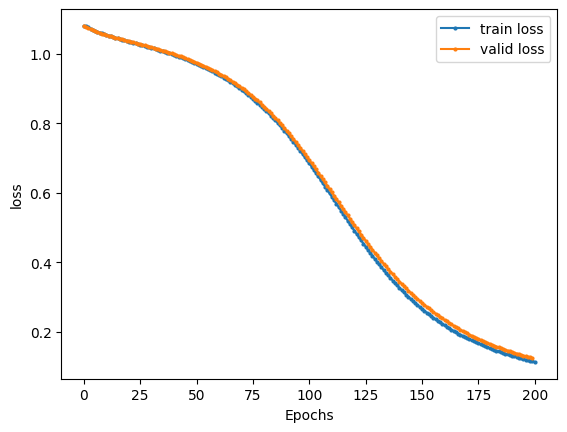

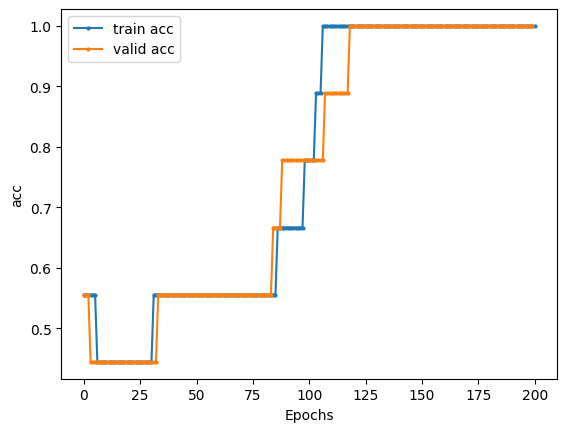

In [ ]:
# TEST Ex1.2-2
# DON'T DELETE THE OUTPUT
plot_results(res)

## Brown corpus

In this exercise we use the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus) for English annotated with the [Universal POS (UPOS) tags](https://www.nltk.org/book/ch05.html#a-universal-part-of-speech-tagset). We can access the data from an NLTK's corpus list. Note that the UPOS tagset contains much fewer tags than the PennTreebank POS tags. This makes UPOS tagging relatively easy.

You are provided with a function `train_validation_split` which extracts two subsets from the given corpus. The size of the subsets can be specified in terms of the ratio to the entire corpus size.

In [ ]:
# defining the corpus view (of type ConcatenatedCorpusView), which can be iterated
BROWN_UPOS = list(nltk.corpus.brown.tagged_sents(tagset='universal'))
# Peeking inside the data
print(BROWN_UPOS[:2])

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [ ]:
# This is how to get training and validation parts of different sizes from the data
# we use seperate_tags=True to format the extracted parts according to the format of the toy datasets,
# i.e., putting tokens and their POS tags in separate lists
sample_train_data, sample_valid_data = train_validation_split(BROWN_UPOS, 0.1, 0.1, seperate_tags=True)
print(f"Training data ({len(sample_train_data)}) and validation data ({len(sample_valid_data)})")

Training data (5734) and validation data (5734)


## Ex1.3a [3pt] Train UPOS tagger

Write a code that initializes a new LSTM tagger with the **embedding dimensionality 32** and **hidden layer dimensionality 16**.
We are opting for the low-dimensional representations to keep the training time reasonable on CPUs.
Note that you will also need to create the mappings of words and tags to indices based on the data.
To be deterministic in creating the mappings, *sort tags and words* with `sorted` and then map sorted elements to indices. For example, this should map the token `!` and the tag `.` to 0s.

Train the tagger on `sample_train_data` with **50 epochs** and evaluate on `sample_valid_data` using your `train_tagger` function. Save the training results in `upos_res` which will be plotted by the test cell.

In [ ]:
### YOUR CODE HERE ###
# save results in upos_res
from collections import defaultdict

w2i = defaultdict(lambda: len(w2i))
t2i = defaultdict(lambda: len(t2i))

for sentence in BROWN_UPOS:
    for word, tag in sentence:
        w2i[word]
        t2i[tag]

w2i = dict(w2i)
t2i = dict(t2i)
model = LSTMTagger((len(w2i), 32), 16, len(t2i))
upos_res = train_tagger(model, sample_train_data, w2i, t2i, valid=sample_valid_data, epoch_num=50,verbose=True)

Epoch 1/50: 100%|██████████| 5734/5734 [00:20<00:00, 276.16it/s]


Epoch 1/50: Avg Loss = 1.0896, Accuracy = 0.6452


Epoch 2/50: 100%|██████████| 5734/5734 [00:21<00:00, 264.20it/s]


Epoch 2/50: Avg Loss = 0.6911, Accuracy = 0.7654


Epoch 3/50: 100%|██████████| 5734/5734 [00:20<00:00, 276.80it/s]


Epoch 3/50: Avg Loss = 0.5977, Accuracy = 0.7911


Epoch 4/50: 100%|██████████| 5734/5734 [00:22<00:00, 253.88it/s]


Epoch 4/50: Avg Loss = 0.5399, Accuracy = 0.8086


Epoch 5/50: 100%|██████████| 5734/5734 [00:21<00:00, 262.48it/s]


Epoch 5/50: Avg Loss = 0.4973, Accuracy = 0.8219


Epoch 6/50: 100%|██████████| 5734/5734 [00:20<00:00, 274.81it/s]


Epoch 6/50: Avg Loss = 0.4634, Accuracy = 0.8323


Epoch 7/50: 100%|██████████| 5734/5734 [00:21<00:00, 266.95it/s]


Epoch 7/50: Avg Loss = 0.4349, Accuracy = 0.8421


Epoch 8/50: 100%|██████████| 5734/5734 [00:20<00:00, 278.79it/s]


Epoch 8/50: Avg Loss = 0.4103, Accuracy = 0.8505


Epoch 9/50: 100%|██████████| 5734/5734 [00:21<00:00, 265.73it/s]


Epoch 9/50: Avg Loss = 0.3884, Accuracy = 0.8575


Epoch 10/50: 100%|██████████| 5734/5734 [00:21<00:00, 270.24it/s]


Epoch 10/50: Avg Loss = 0.3686, Accuracy = 0.8640


Epoch 11/50: 100%|██████████| 5734/5734 [00:20<00:00, 279.58it/s]


Epoch 11/50: Avg Loss = 0.3506, Accuracy = 0.8703


Epoch 12/50: 100%|██████████| 5734/5734 [00:21<00:00, 268.10it/s]


Epoch 12/50: Avg Loss = 0.3342, Accuracy = 0.8757


Epoch 13/50: 100%|██████████| 5734/5734 [00:20<00:00, 275.73it/s]


Epoch 13/50: Avg Loss = 0.3188, Accuracy = 0.8806


Epoch 14/50: 100%|██████████| 5734/5734 [00:21<00:00, 272.95it/s]


Epoch 14/50: Avg Loss = 0.3045, Accuracy = 0.8853


Epoch 15/50: 100%|██████████| 5734/5734 [00:21<00:00, 264.24it/s]


Epoch 15/50: Avg Loss = 0.2912, Accuracy = 0.8895


Epoch 16/50: 100%|██████████| 5734/5734 [00:20<00:00, 275.20it/s]


Epoch 16/50: Avg Loss = 0.2787, Accuracy = 0.8937


Epoch 17/50: 100%|██████████| 5734/5734 [00:21<00:00, 265.32it/s]


Epoch 17/50: Avg Loss = 0.2671, Accuracy = 0.8977


Epoch 18/50: 100%|██████████| 5734/5734 [00:21<00:00, 265.27it/s]


Epoch 18/50: Avg Loss = 0.2561, Accuracy = 0.9013


Epoch 19/50: 100%|██████████| 5734/5734 [00:21<00:00, 272.23it/s]


Epoch 19/50: Avg Loss = 0.2458, Accuracy = 0.9051


Epoch 20/50: 100%|██████████| 5734/5734 [00:21<00:00, 264.57it/s]


Epoch 20/50: Avg Loss = 0.2361, Accuracy = 0.9088


Epoch 21/50: 100%|██████████| 5734/5734 [00:21<00:00, 271.02it/s]


Epoch 21/50: Avg Loss = 0.2270, Accuracy = 0.9122


Epoch 22/50: 100%|██████████| 5734/5734 [00:21<00:00, 267.88it/s]


Epoch 22/50: Avg Loss = 0.2184, Accuracy = 0.9149


Epoch 23/50: 100%|██████████| 5734/5734 [00:21<00:00, 269.28it/s]


Epoch 23/50: Avg Loss = 0.2105, Accuracy = 0.9181


Epoch 24/50: 100%|██████████| 5734/5734 [00:21<00:00, 265.83it/s]


Epoch 24/50: Avg Loss = 0.2030, Accuracy = 0.9207


Epoch 25/50: 100%|██████████| 5734/5734 [00:21<00:00, 266.59it/s]


Epoch 25/50: Avg Loss = 0.1959, Accuracy = 0.9231


Epoch 26/50: 100%|██████████| 5734/5734 [00:20<00:00, 277.84it/s]


Epoch 26/50: Avg Loss = 0.1891, Accuracy = 0.9254


Epoch 27/50: 100%|██████████| 5734/5734 [00:21<00:00, 268.53it/s]


Epoch 27/50: Avg Loss = 0.1827, Accuracy = 0.9276


Epoch 28/50: 100%|██████████| 5734/5734 [00:21<00:00, 267.15it/s]


Epoch 28/50: Avg Loss = 0.1766, Accuracy = 0.9300


Epoch 29/50: 100%|██████████| 5734/5734 [00:21<00:00, 271.79it/s]


Epoch 29/50: Avg Loss = 0.1707, Accuracy = 0.9323


Epoch 30/50: 100%|██████████| 5734/5734 [00:20<00:00, 275.99it/s]


Epoch 30/50: Avg Loss = 0.1652, Accuracy = 0.9344


Epoch 31/50: 100%|██████████| 5734/5734 [00:20<00:00, 278.20it/s]


Epoch 31/50: Avg Loss = 0.1599, Accuracy = 0.9360


Epoch 32/50: 100%|██████████| 5734/5734 [00:20<00:00, 281.42it/s]


Epoch 32/50: Avg Loss = 0.1548, Accuracy = 0.9381


Epoch 33/50: 100%|██████████| 5734/5734 [00:20<00:00, 276.56it/s]


Epoch 33/50: Avg Loss = 0.1500, Accuracy = 0.9398


Epoch 34/50: 100%|██████████| 5734/5734 [00:21<00:00, 270.96it/s]


Epoch 34/50: Avg Loss = 0.1454, Accuracy = 0.9416


Epoch 35/50: 100%|██████████| 5734/5734 [00:20<00:00, 280.97it/s]


Epoch 35/50: Avg Loss = 0.1410, Accuracy = 0.9431


Epoch 36/50: 100%|██████████| 5734/5734 [00:20<00:00, 273.17it/s]


Epoch 36/50: Avg Loss = 0.1367, Accuracy = 0.9447


Epoch 37/50: 100%|██████████| 5734/5734 [00:20<00:00, 273.81it/s]


Epoch 37/50: Avg Loss = 0.1327, Accuracy = 0.9461


Epoch 38/50: 100%|██████████| 5734/5734 [00:21<00:00, 269.43it/s]


Epoch 38/50: Avg Loss = 0.1290, Accuracy = 0.9475


Epoch 39/50: 100%|██████████| 5734/5734 [00:21<00:00, 272.57it/s]


Epoch 39/50: Avg Loss = 0.1253, Accuracy = 0.9490


Epoch 40/50: 100%|██████████| 5734/5734 [00:20<00:00, 275.44it/s]


Epoch 40/50: Avg Loss = 0.1218, Accuracy = 0.9505


Epoch 41/50: 100%|██████████| 5734/5734 [00:20<00:00, 281.66it/s]


Epoch 41/50: Avg Loss = 0.1184, Accuracy = 0.9518


Epoch 42/50: 100%|██████████| 5734/5734 [00:21<00:00, 264.96it/s]


Epoch 42/50: Avg Loss = 0.1153, Accuracy = 0.9529


Epoch 43/50: 100%|██████████| 5734/5734 [00:21<00:00, 266.95it/s]


Epoch 43/50: Avg Loss = 0.1124, Accuracy = 0.9540


Epoch 44/50: 100%|██████████| 5734/5734 [00:21<00:00, 270.36it/s]


Epoch 44/50: Avg Loss = 0.1096, Accuracy = 0.9551


Epoch 45/50: 100%|██████████| 5734/5734 [00:21<00:00, 264.29it/s]


Epoch 45/50: Avg Loss = 0.1070, Accuracy = 0.9560


Epoch 46/50: 100%|██████████| 5734/5734 [00:20<00:00, 279.13it/s]


Epoch 46/50: Avg Loss = 0.1043, Accuracy = 0.9570


Epoch 47/50: 100%|██████████| 5734/5734 [00:21<00:00, 265.89it/s]


Epoch 47/50: Avg Loss = 0.1019, Accuracy = 0.9579


Epoch 48/50: 100%|██████████| 5734/5734 [00:20<00:00, 274.22it/s]


Epoch 48/50: Avg Loss = 0.0997, Accuracy = 0.9588


Epoch 49/50: 100%|██████████| 5734/5734 [00:20<00:00, 286.42it/s]


Epoch 49/50: Avg Loss = 0.0975, Accuracy = 0.9598


Epoch 50/50: 100%|██████████| 5734/5734 [00:20<00:00, 277.06it/s]


Epoch 50/50: Avg Loss = 0.0952, Accuracy = 0.9604


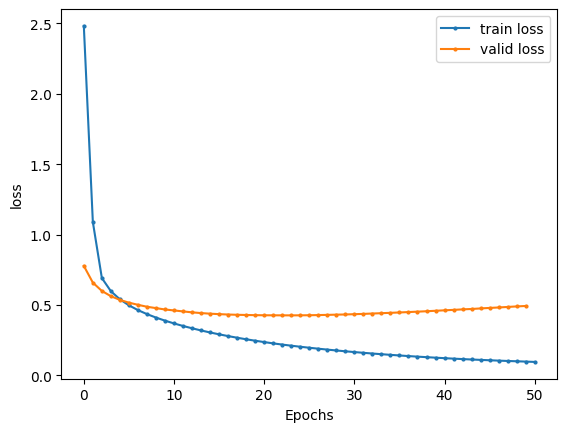

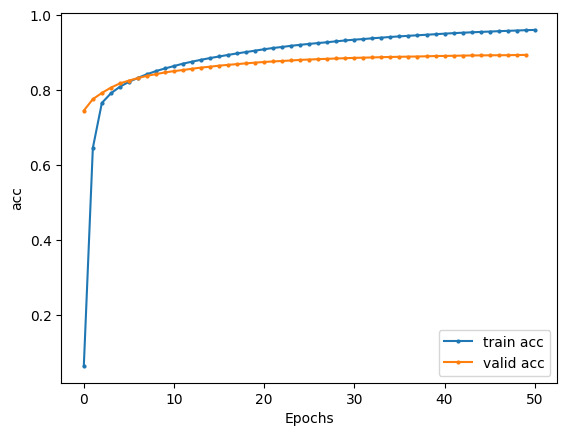

In [ ]:
# TEST Ex1.3
# DON'T DELETE THE OUTPUT
plot_results(upos_res)

## Q1.3b [2pt] Best model

Based on the training dynamics of the accuracy scores on the training and validation parts, after which epoch (if any) is recommended to stop training and why?

<font color="red">█████ YOUR ANSWER HERE █████</font>

Based on these graphics, it would be useful to stop the training after the 15 epoch as it occurs the intersection between validation and training curves. It will be overfitting from this point on. The training accuracy will keep increasing while the validation accuracy remains the same so there is no point in keep training with the same data after epoch 8 because the model won't learn anything useful to generalize and it will become dependant on the training data (overfiting).

## GloVe embeddings

In this section we are downloading the [GloVe](https://nlp.stanford.edu/projects/glove/) pre-trained static word embeddings. We will reuse it to initialize the embedding layer of an LSTM, as opposed to the random initialization we have been using so far.

In [ ]:
# downloading from the Dutch server (should be a bit faster than the original source)
GLOVE_FILE = "glove.6B.100d.txt"
!wget -nv https://naturallogic.pro/_files_/download/mNLP/{GLOVE_FILE}.bz2
!bzip2 -dk glove.6B.100d.txt.bz2

2024-06-11 08:10:38 URL:https://naturallogic.pro/_files_/download/mNLP/glove.6B.100d.txt.bz2 [107798047/107798047] -> "glove.6B.100d.txt.bz2" [1]


In [ ]:
# Loading vectors from the file
from torchtext.vocab import Vectors
glove = Vectors(GLOVE_FILE, cache=".")
print(glove.vectors.shape)

100%|█████████▉| 399999/400000 [00:20<00:00, 19362.36it/s]


torch.Size([400000, 100])


GloVe comes with its own word-to-index mapping: `stoi` (strings to indices). You can access each word's vector as shown below.

In [ ]:
word1 = "human" #@param {type:"string"}
word2 = "" #@param {type:"string"}
if word1 and word2:
    tensor1 = glove.vectors[glove.stoi[word1]]
    tensor2 = glove.vectors[glove.stoi[word2]]
    sim = F.cosine_similarity(tensor1, tensor2, dim=0).item()
    print(f"similarity({word1}, {word2}) = {sim}")
elif word1:
    print(f"The index is {glove.stoi[word1]}")
    print(f"The vector is {glove.vectors[glove.stoi[word1]]}")

The index is 473
The vector is tensor([ 3.3864e-01,  5.9663e-01,  5.3322e-01,  3.1404e-01,  1.5321e-01,
         3.1749e-01, -4.2940e-01, -2.9150e-01, -2.1047e-03, -3.9309e-01,
        -8.5441e-01, -8.0708e-02,  1.2118e+00,  6.9316e-02,  8.0613e-03,
         8.7888e-01,  3.1908e-02,  5.8655e-01, -5.4892e-01, -7.8468e-03,
         1.7327e-01, -2.6693e-01,  4.2802e-01,  6.6123e-02,  5.1847e-01,
         7.7226e-01,  2.0608e-01, -4.5836e-01,  3.5485e-01,  7.1547e-01,
         6.0855e-01,  2.0254e-01, -4.8756e-01,  5.7974e-01,  8.6728e-02,
        -5.1852e-01, -3.7274e-01,  1.0014e+00, -2.9259e-01,  3.2290e-01,
        -9.7563e-01, -2.2288e-01, -2.3335e-01, -2.6891e-01,  1.4612e-01,
         1.2004e-01, -2.0402e-01, -9.4647e-02, -1.5402e+00, -5.9510e-02,
         1.0887e+00, -2.4998e-01, -2.5808e-01,  1.2798e+00, -1.2849e-01,
        -1.4511e+00, -2.4686e-01, -9.5046e-02,  1.7425e+00,  1.1977e-01,
        -1.9206e-01,  4.4368e-01, -1.6453e-01, -7.6663e-01,  1.1100e+00,
         4.6748e-01,

## Ex1.4a [8pt] Random vs GloVe

In this exercise we are comparing two LSTM-based UPOS taggers, one with randomly initialized embeddings while another reusing the GloVe embeddings.
To bolster the comparison, we will restrict the data only to those tagged sentences that consist of the words covered by the GloVe vectors (Note that GloVe covers 400K words). This also helps to reduce the data and make the experiments feasible for the colab's CPU.

Complete the designated code cell below so that it runs the following experiment:

1.   For each train & valid data split initialize two LSTM-based taggers, with the random and GloVe embeddings.
2.   Train each tagger with a predefined number of epochs. Obviously, you should reuse `train_tagger` function here.
3.   After the training is done, record the max/best score across the epochs on the validation part (because the validation score better represents the model's capacity than the training data). Use `best_valid_acc` to keep track of the best scores for each type of embedding initialization.

One important detail! This is an example of how to initialize an LSTM tagger with the GloVe word vectors that is expected to predict $N$ number of tags.
Remember, this was the reason why we modified the LSTMTagger class from the PyTorch tutorial.

```
LSTMTagger(glove.vectors, HIDDEN_DIM, N)
```

In [ ]:
EMB_DIM = glove.vectors.size(1)
HID_DIM = 20
valid_ratio = 0.2
train_ratios = [0.01, 0.02, 0.04, 0.1, 0.2, 0.4, 0.8]
epoch_num = 50
# keep the best accuracy on the valid part here. Keys
best_valid_acc = {'glove':[], 'random':[]}
# For better contrast, we are keeping only those sentences in the Brown corpus for which we have GloVe vectors
# and also keep only those sentences that have 3 and more tokens
GLOVE_BROWN = [ sent for sent in BROWN_UPOS if len(sent) > 2 and all([ w in glove.stoi for w, _ in sent ]) ]
print(f"New data size = {len(GLOVE_BROWN)}")

New data size = 1589


In [ ]:
# It should take less than 15mins
### YOUR CODE HERE ###

w2i_glove = defaultdict(lambda: len(w2i_glove))
t2i_glove = defaultdict(lambda: len(t2i_glove))

for sentence in GLOVE_BROWN:
    for word, tag in sentence:
        w2i_glove[word]
        t2i_glove[tag]

w2i_glove = dict(w2i_glove)
t2i_glove = dict(t2i_glove)

for train_ratio in train_ratios:
  train_data, valid_data = train_validation_split(GLOVE_BROWN, train_ratio, valid_ratio, seperate_tags=True)

  random_model = LSTMTagger((len(w2i_glove), EMB_DIM), HID_DIM, len(t2i_glove))
  random_res = train_tagger(random_model, train_data, w2i_glove, t2i_glove, valid=valid_data, epoch_num=epoch_num, verbose=True)

  glove_model = LSTMTagger(glove.vectors, HID_DIM, len(t2i_glove))
  glove_res = train_tagger(glove_model, train_data, glove.stoi, t2i_glove, valid=valid_data, epoch_num=epoch_num,verbose=True)

  best_valid_acc["glove"].append(glove_res["valid"]["best_acc"])
  best_valid_acc["random"].append(random_res["valid"]["best_acc"])

Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 383.83it/s]

Epoch 1/50: Avg Loss = 2.4144, Accuracy = 0.1600



Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 481.16it/s]


Epoch 2/50: Avg Loss = 2.2543, Accuracy = 0.3200


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 481.25it/s]


Epoch 3/50: Avg Loss = 2.1200, Accuracy = 0.3667


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 460.44it/s]


Epoch 4/50: Avg Loss = 1.9954, Accuracy = 0.4200


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 422.61it/s]


Epoch 5/50: Avg Loss = 1.8748, Accuracy = 0.4600


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 439.61it/s]


Epoch 6/50: Avg Loss = 1.7582, Accuracy = 0.4667


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 474.98it/s]


Epoch 7/50: Avg Loss = 1.6485, Accuracy = 0.4733


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 457.97it/s]


Epoch 8/50: Avg Loss = 1.5482, Accuracy = 0.4733


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 312.19it/s]


Epoch 9/50: Avg Loss = 1.4577, Accuracy = 0.4800


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 336.14it/s]


Epoch 10/50: Avg Loss = 1.3757, Accuracy = 0.5200


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 336.70it/s]


Epoch 11/50: Avg Loss = 1.3008, Accuracy = 0.5400


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 317.86it/s]


Epoch 12/50: Avg Loss = 1.2313, Accuracy = 0.5600


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 284.48it/s]


Epoch 13/50: Avg Loss = 1.1661, Accuracy = 0.5667


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 318.98it/s]


Epoch 14/50: Avg Loss = 1.1044, Accuracy = 0.5867


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 319.98it/s]


Epoch 15/50: Avg Loss = 1.0457, Accuracy = 0.6200


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 469.06it/s]


Epoch 16/50: Avg Loss = 0.9898, Accuracy = 0.6533


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 473.12it/s]


Epoch 17/50: Avg Loss = 0.9365, Accuracy = 0.7000


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 467.13it/s]


Epoch 18/50: Avg Loss = 0.8860, Accuracy = 0.7200


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 462.98it/s]


Epoch 19/50: Avg Loss = 0.8384, Accuracy = 0.7400


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 491.21it/s]


Epoch 20/50: Avg Loss = 0.7937, Accuracy = 0.7600


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 435.84it/s]


Epoch 21/50: Avg Loss = 0.7520, Accuracy = 0.7667


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 481.73it/s]


Epoch 22/50: Avg Loss = 0.7130, Accuracy = 0.7667


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 490.07it/s]


Epoch 23/50: Avg Loss = 0.6767, Accuracy = 0.7867


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 455.21it/s]


Epoch 24/50: Avg Loss = 0.6428, Accuracy = 0.7867


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 462.51it/s]


Epoch 25/50: Avg Loss = 0.6110, Accuracy = 0.8067


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 451.78it/s]


Epoch 26/50: Avg Loss = 0.5811, Accuracy = 0.8133


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 439.41it/s]


Epoch 27/50: Avg Loss = 0.5530, Accuracy = 0.8400


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 466.40it/s]


Epoch 28/50: Avg Loss = 0.5264, Accuracy = 0.8400


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 450.69it/s]


Epoch 29/50: Avg Loss = 0.5013, Accuracy = 0.8600


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 478.05it/s]


Epoch 30/50: Avg Loss = 0.4775, Accuracy = 0.8667


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 435.78it/s]


Epoch 31/50: Avg Loss = 0.4548, Accuracy = 0.8800


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 478.62it/s]


Epoch 32/50: Avg Loss = 0.4332, Accuracy = 0.8867


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 383.77it/s]


Epoch 33/50: Avg Loss = 0.4127, Accuracy = 0.9000


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 430.71it/s]


Epoch 34/50: Avg Loss = 0.3931, Accuracy = 0.9067


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 471.14it/s]


Epoch 35/50: Avg Loss = 0.3745, Accuracy = 0.9067


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 369.09it/s]


Epoch 36/50: Avg Loss = 0.3567, Accuracy = 0.9133


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 466.09it/s]


Epoch 37/50: Avg Loss = 0.3398, Accuracy = 0.9200


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 388.76it/s]


Epoch 38/50: Avg Loss = 0.3237, Accuracy = 0.9267


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 438.55it/s]


Epoch 39/50: Avg Loss = 0.3085, Accuracy = 0.9333


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 328.79it/s]


Epoch 40/50: Avg Loss = 0.2939, Accuracy = 0.9467


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 358.76it/s]


Epoch 41/50: Avg Loss = 0.2802, Accuracy = 0.9600


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 337.34it/s]


Epoch 42/50: Avg Loss = 0.2671, Accuracy = 0.9667


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 329.33it/s]


Epoch 43/50: Avg Loss = 0.2547, Accuracy = 0.9667


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 321.16it/s]


Epoch 44/50: Avg Loss = 0.2430, Accuracy = 0.9667


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 327.09it/s]


Epoch 45/50: Avg Loss = 0.2319, Accuracy = 0.9733


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 333.41it/s]


Epoch 46/50: Avg Loss = 0.2214, Accuracy = 0.9800


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 433.08it/s]


Epoch 47/50: Avg Loss = 0.2114, Accuracy = 0.9800


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 475.01it/s]


Epoch 48/50: Avg Loss = 0.2020, Accuracy = 0.9867


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 464.92it/s]


Epoch 49/50: Avg Loss = 0.1931, Accuracy = 0.9933


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 453.06it/s]


Epoch 50/50: Avg Loss = 0.1847, Accuracy = 0.9933


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 516.02it/s]


Epoch 1/50: Avg Loss = 2.4000, Accuracy = 0.1933


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 413.04it/s]


Epoch 2/50: Avg Loss = 2.2600, Accuracy = 0.2400


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 556.04it/s]


Epoch 3/50: Avg Loss = 2.1644, Accuracy = 0.2400


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 559.36it/s]


Epoch 4/50: Avg Loss = 2.0916, Accuracy = 0.2533


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 574.40it/s]


Epoch 5/50: Avg Loss = 2.0258, Accuracy = 0.3000


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 557.66it/s]


Epoch 6/50: Avg Loss = 1.9560, Accuracy = 0.3800


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 469.69it/s]


Epoch 7/50: Avg Loss = 1.8770, Accuracy = 0.4267


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 563.36it/s]


Epoch 8/50: Avg Loss = 1.7896, Accuracy = 0.4933


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 555.47it/s]


Epoch 9/50: Avg Loss = 1.6994, Accuracy = 0.4933


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 548.75it/s]


Epoch 10/50: Avg Loss = 1.6120, Accuracy = 0.5067


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 561.89it/s]


Epoch 11/50: Avg Loss = 1.5301, Accuracy = 0.5333


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 514.10it/s]


Epoch 12/50: Avg Loss = 1.4538, Accuracy = 0.5400


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 556.19it/s]


Epoch 13/50: Avg Loss = 1.3826, Accuracy = 0.5600


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 540.11it/s]


Epoch 14/50: Avg Loss = 1.3164, Accuracy = 0.5667


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 547.89it/s]


Epoch 15/50: Avg Loss = 1.2541, Accuracy = 0.6067


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 551.48it/s]


Epoch 16/50: Avg Loss = 1.1937, Accuracy = 0.6067


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 546.77it/s]


Epoch 17/50: Avg Loss = 1.1353, Accuracy = 0.6600


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 568.55it/s]


Epoch 18/50: Avg Loss = 1.0801, Accuracy = 0.6933


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 544.38it/s]


Epoch 19/50: Avg Loss = 1.0281, Accuracy = 0.6933


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 548.61it/s]


Epoch 20/50: Avg Loss = 0.9787, Accuracy = 0.7067


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 570.74it/s]


Epoch 21/50: Avg Loss = 0.9319, Accuracy = 0.7067


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 399.87it/s]


Epoch 22/50: Avg Loss = 0.8875, Accuracy = 0.7067


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 432.44it/s]


Epoch 23/50: Avg Loss = 0.8456, Accuracy = 0.7133


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 393.54it/s]


Epoch 24/50: Avg Loss = 0.8061, Accuracy = 0.7200


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 393.25it/s]


Epoch 25/50: Avg Loss = 0.7688, Accuracy = 0.7267


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 414.75it/s]


Epoch 26/50: Avg Loss = 0.7334, Accuracy = 0.7333


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 340.43it/s]


Epoch 27/50: Avg Loss = 0.6999, Accuracy = 0.7533


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 360.39it/s]


Epoch 28/50: Avg Loss = 0.6679, Accuracy = 0.7733


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 565.84it/s]


Epoch 29/50: Avg Loss = 0.6375, Accuracy = 0.7867


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 560.67it/s]


Epoch 30/50: Avg Loss = 0.6085, Accuracy = 0.8067


Epoch 31/50: 100%|██████████| 15/15 [00:00<00:00, 569.08it/s]


Epoch 31/50: Avg Loss = 0.5807, Accuracy = 0.8400


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 455.89it/s]


Epoch 32/50: Avg Loss = 0.5542, Accuracy = 0.8533


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 543.16it/s]


Epoch 33/50: Avg Loss = 0.5289, Accuracy = 0.8600


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 578.85it/s]


Epoch 34/50: Avg Loss = 0.5048, Accuracy = 0.8600


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 550.47it/s]


Epoch 35/50: Avg Loss = 0.4817, Accuracy = 0.8733


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 556.94it/s]


Epoch 36/50: Avg Loss = 0.4598, Accuracy = 0.8933


Epoch 37/50: 100%|██████████| 15/15 [00:00<00:00, 528.60it/s]


Epoch 37/50: Avg Loss = 0.4390, Accuracy = 0.9067


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 557.37it/s]


Epoch 38/50: Avg Loss = 0.4192, Accuracy = 0.9133


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 535.67it/s]


Epoch 39/50: Avg Loss = 0.4006, Accuracy = 0.9133


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 561.18it/s]


Epoch 40/50: Avg Loss = 0.3831, Accuracy = 0.9133


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 515.34it/s]


Epoch 41/50: Avg Loss = 0.3665, Accuracy = 0.9133


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 560.11it/s]


Epoch 42/50: Avg Loss = 0.3507, Accuracy = 0.9200


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 538.22it/s]


Epoch 43/50: Avg Loss = 0.3358, Accuracy = 0.9200


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 544.60it/s]


Epoch 44/50: Avg Loss = 0.3217, Accuracy = 0.9333


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 551.34it/s]


Epoch 45/50: Avg Loss = 0.3083, Accuracy = 0.9333


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 543.24it/s]


Epoch 46/50: Avg Loss = 0.2955, Accuracy = 0.9333


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 562.67it/s]


Epoch 47/50: Avg Loss = 0.2835, Accuracy = 0.9400


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 556.50it/s]


Epoch 48/50: Avg Loss = 0.2721, Accuracy = 0.9400


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 561.22it/s]


Epoch 49/50: Avg Loss = 0.2612, Accuracy = 0.9467


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 561.86it/s]


Epoch 50/50: Avg Loss = 0.2509, Accuracy = 0.9533


Epoch 1/50: 100%|██████████| 31/31 [00:00<00:00, 435.08it/s]


Epoch 1/50: Avg Loss = 2.3790, Accuracy = 0.2466


Epoch 2/50: 100%|██████████| 31/31 [00:00<00:00, 422.05it/s]


Epoch 2/50: Avg Loss = 2.1897, Accuracy = 0.3516


Epoch 3/50: 100%|██████████| 31/31 [00:00<00:00, 277.87it/s]


Epoch 3/50: Avg Loss = 2.0270, Accuracy = 0.3881


Epoch 4/50: 100%|██████████| 31/31 [00:00<00:00, 318.71it/s]


Epoch 4/50: Avg Loss = 1.8692, Accuracy = 0.3904


Epoch 5/50: 100%|██████████| 31/31 [00:00<00:00, 318.64it/s]


Epoch 5/50: Avg Loss = 1.7275, Accuracy = 0.4041


Epoch 6/50: 100%|██████████| 31/31 [00:00<00:00, 309.64it/s]


Epoch 6/50: Avg Loss = 1.6075, Accuracy = 0.4269


Epoch 7/50: 100%|██████████| 31/31 [00:00<00:00, 309.37it/s]


Epoch 7/50: Avg Loss = 1.5031, Accuracy = 0.4543


Epoch 8/50: 100%|██████████| 31/31 [00:00<00:00, 279.47it/s]


Epoch 8/50: Avg Loss = 1.4078, Accuracy = 0.5000


Epoch 9/50: 100%|██████████| 31/31 [00:00<00:00, 307.50it/s]


Epoch 9/50: Avg Loss = 1.3179, Accuracy = 0.5411


Epoch 10/50: 100%|██████████| 31/31 [00:00<00:00, 437.59it/s]


Epoch 10/50: Avg Loss = 1.2318, Accuracy = 0.5776


Epoch 11/50: 100%|██████████| 31/31 [00:00<00:00, 430.14it/s]


Epoch 11/50: Avg Loss = 1.1492, Accuracy = 0.6233


Epoch 12/50: 100%|██████████| 31/31 [00:00<00:00, 419.15it/s]


Epoch 12/50: Avg Loss = 1.0701, Accuracy = 0.6644


Epoch 13/50: 100%|██████████| 31/31 [00:00<00:00, 444.15it/s]


Epoch 13/50: Avg Loss = 0.9945, Accuracy = 0.6826


Epoch 14/50: 100%|██████████| 31/31 [00:00<00:00, 382.32it/s]


Epoch 14/50: Avg Loss = 0.9224, Accuracy = 0.7009


Epoch 15/50: 100%|██████████| 31/31 [00:00<00:00, 445.08it/s]


Epoch 15/50: Avg Loss = 0.8543, Accuracy = 0.7329


Epoch 16/50: 100%|██████████| 31/31 [00:00<00:00, 457.37it/s]


Epoch 16/50: Avg Loss = 0.7904, Accuracy = 0.7580


Epoch 17/50: 100%|██████████| 31/31 [00:00<00:00, 438.06it/s]


Epoch 17/50: Avg Loss = 0.7311, Accuracy = 0.7808


Epoch 18/50: 100%|██████████| 31/31 [00:00<00:00, 456.46it/s]


Epoch 18/50: Avg Loss = 0.6764, Accuracy = 0.7945


Epoch 19/50: 100%|██████████| 31/31 [00:00<00:00, 424.21it/s]


Epoch 19/50: Avg Loss = 0.6262, Accuracy = 0.8037


Epoch 20/50: 100%|██████████| 31/31 [00:00<00:00, 451.38it/s]


Epoch 20/50: Avg Loss = 0.5801, Accuracy = 0.8196


Epoch 21/50: 100%|██████████| 31/31 [00:00<00:00, 433.30it/s]


Epoch 21/50: Avg Loss = 0.5376, Accuracy = 0.8265


Epoch 22/50: 100%|██████████| 31/31 [00:00<00:00, 459.12it/s]


Epoch 22/50: Avg Loss = 0.4986, Accuracy = 0.8516


Epoch 23/50: 100%|██████████| 31/31 [00:00<00:00, 457.90it/s]


Epoch 23/50: Avg Loss = 0.4626, Accuracy = 0.8676


Epoch 24/50: 100%|██████████| 31/31 [00:00<00:00, 450.56it/s]


Epoch 24/50: Avg Loss = 0.4294, Accuracy = 0.8858


Epoch 25/50: 100%|██████████| 31/31 [00:00<00:00, 444.83it/s]


Epoch 25/50: Avg Loss = 0.3988, Accuracy = 0.8973


Epoch 26/50: 100%|██████████| 31/31 [00:00<00:00, 430.86it/s]


Epoch 26/50: Avg Loss = 0.3706, Accuracy = 0.9041


Epoch 27/50: 100%|██████████| 31/31 [00:00<00:00, 426.19it/s]


Epoch 27/50: Avg Loss = 0.3447, Accuracy = 0.9178


Epoch 28/50: 100%|██████████| 31/31 [00:00<00:00, 434.54it/s]


Epoch 28/50: Avg Loss = 0.3208, Accuracy = 0.9269


Epoch 29/50: 100%|██████████| 31/31 [00:00<00:00, 421.79it/s]


Epoch 29/50: Avg Loss = 0.2989, Accuracy = 0.9338


Epoch 30/50: 100%|██████████| 31/31 [00:00<00:00, 417.43it/s]


Epoch 30/50: Avg Loss = 0.2788, Accuracy = 0.9429


Epoch 31/50: 100%|██████████| 31/31 [00:00<00:00, 451.79it/s]


Epoch 31/50: Avg Loss = 0.2602, Accuracy = 0.9543


Epoch 32/50: 100%|██████████| 31/31 [00:00<00:00, 378.87it/s]


Epoch 32/50: Avg Loss = 0.2431, Accuracy = 0.9658


Epoch 33/50: 100%|██████████| 31/31 [00:00<00:00, 318.13it/s]


Epoch 33/50: Avg Loss = 0.2272, Accuracy = 0.9726


Epoch 34/50: 100%|██████████| 31/31 [00:00<00:00, 321.20it/s]


Epoch 34/50: Avg Loss = 0.2126, Accuracy = 0.9726


Epoch 35/50: 100%|██████████| 31/31 [00:00<00:00, 277.89it/s]


Epoch 35/50: Avg Loss = 0.1991, Accuracy = 0.9749


Epoch 36/50: 100%|██████████| 31/31 [00:00<00:00, 276.25it/s]


Epoch 36/50: Avg Loss = 0.1866, Accuracy = 0.9772


Epoch 37/50: 100%|██████████| 31/31 [00:00<00:00, 249.07it/s]


Epoch 37/50: Avg Loss = 0.1751, Accuracy = 0.9795


Epoch 38/50: 100%|██████████| 31/31 [00:00<00:00, 287.74it/s]


Epoch 38/50: Avg Loss = 0.1645, Accuracy = 0.9840


Epoch 39/50: 100%|██████████| 31/31 [00:00<00:00, 279.29it/s]


Epoch 39/50: Avg Loss = 0.1547, Accuracy = 0.9840


Epoch 40/50: 100%|██████████| 31/31 [00:00<00:00, 442.94it/s]


Epoch 40/50: Avg Loss = 0.1457, Accuracy = 0.9840


Epoch 41/50: 100%|██████████| 31/31 [00:00<00:00, 432.92it/s]


Epoch 41/50: Avg Loss = 0.1374, Accuracy = 0.9863


Epoch 42/50: 100%|██████████| 31/31 [00:00<00:00, 450.42it/s]


Epoch 42/50: Avg Loss = 0.1298, Accuracy = 0.9863


Epoch 43/50: 100%|██████████| 31/31 [00:00<00:00, 400.06it/s]


Epoch 43/50: Avg Loss = 0.1228, Accuracy = 0.9886


Epoch 44/50: 100%|██████████| 31/31 [00:00<00:00, 450.53it/s]


Epoch 44/50: Avg Loss = 0.1164, Accuracy = 0.9886


Epoch 45/50: 100%|██████████| 31/31 [00:00<00:00, 465.02it/s]


Epoch 45/50: Avg Loss = 0.1104, Accuracy = 0.9909


Epoch 46/50: 100%|██████████| 31/31 [00:00<00:00, 448.79it/s]


Epoch 46/50: Avg Loss = 0.1050, Accuracy = 0.9909


Epoch 47/50: 100%|██████████| 31/31 [00:00<00:00, 446.95it/s]


Epoch 47/50: Avg Loss = 0.0999, Accuracy = 0.9909


Epoch 48/50: 100%|██████████| 31/31 [00:00<00:00, 406.77it/s]


Epoch 48/50: Avg Loss = 0.0952, Accuracy = 0.9909


Epoch 49/50: 100%|██████████| 31/31 [00:00<00:00, 429.18it/s]


Epoch 49/50: Avg Loss = 0.0909, Accuracy = 0.9909


Epoch 50/50: 100%|██████████| 31/31 [00:00<00:00, 448.69it/s]


Epoch 50/50: Avg Loss = 0.0869, Accuracy = 0.9909


Epoch 1/50: 100%|██████████| 31/31 [00:00<00:00, 533.13it/s]


Epoch 1/50: Avg Loss = 2.3698, Accuracy = 0.1849


Epoch 2/50: 100%|██████████| 31/31 [00:00<00:00, 535.03it/s]


Epoch 2/50: Avg Loss = 2.2210, Accuracy = 0.2352


Epoch 3/50: 100%|██████████| 31/31 [00:00<00:00, 518.08it/s]


Epoch 3/50: Avg Loss = 2.1273, Accuracy = 0.3105


Epoch 4/50: 100%|██████████| 31/31 [00:00<00:00, 511.70it/s]


Epoch 4/50: Avg Loss = 2.0241, Accuracy = 0.4155


Epoch 5/50: 100%|██████████| 31/31 [00:00<00:00, 436.87it/s]


Epoch 5/50: Avg Loss = 1.8856, Accuracy = 0.4384


Epoch 6/50: 100%|██████████| 31/31 [00:00<00:00, 460.32it/s]


Epoch 6/50: Avg Loss = 1.7286, Accuracy = 0.4840


Epoch 7/50: 100%|██████████| 31/31 [00:00<00:00, 517.23it/s]


Epoch 7/50: Avg Loss = 1.5815, Accuracy = 0.5205


Epoch 8/50: 100%|██████████| 31/31 [00:00<00:00, 525.32it/s]


Epoch 8/50: Avg Loss = 1.4531, Accuracy = 0.5616


Epoch 9/50: 100%|██████████| 31/31 [00:00<00:00, 448.84it/s]


Epoch 9/50: Avg Loss = 1.3392, Accuracy = 0.6005


Epoch 10/50: 100%|██████████| 31/31 [00:00<00:00, 507.85it/s]


Epoch 10/50: Avg Loss = 1.2365, Accuracy = 0.6324


Epoch 11/50: 100%|██████████| 31/31 [00:00<00:00, 519.83it/s]


Epoch 11/50: Avg Loss = 1.1433, Accuracy = 0.6416


Epoch 12/50: 100%|██████████| 31/31 [00:00<00:00, 365.30it/s]


Epoch 12/50: Avg Loss = 1.0597, Accuracy = 0.6621


Epoch 13/50: 100%|██████████| 31/31 [00:00<00:00, 347.87it/s]


Epoch 13/50: Avg Loss = 0.9856, Accuracy = 0.6826


Epoch 14/50: 100%|██████████| 31/31 [00:00<00:00, 363.43it/s]


Epoch 14/50: Avg Loss = 0.9196, Accuracy = 0.7146


Epoch 15/50: 100%|██████████| 31/31 [00:00<00:00, 371.83it/s]


Epoch 15/50: Avg Loss = 0.8605, Accuracy = 0.7283


Epoch 16/50: 100%|██████████| 31/31 [00:00<00:00, 350.48it/s]


Epoch 16/50: Avg Loss = 0.8071, Accuracy = 0.7352


Epoch 17/50: 100%|██████████| 31/31 [00:00<00:00, 347.55it/s]


Epoch 17/50: Avg Loss = 0.7582, Accuracy = 0.7489


Epoch 18/50: 100%|██████████| 31/31 [00:00<00:00, 343.61it/s]


Epoch 18/50: Avg Loss = 0.7135, Accuracy = 0.7740


Epoch 19/50: 100%|██████████| 31/31 [00:00<00:00, 525.38it/s]


Epoch 19/50: Avg Loss = 0.6729, Accuracy = 0.7854


Epoch 20/50: 100%|██████████| 31/31 [00:00<00:00, 518.49it/s]


Epoch 20/50: Avg Loss = 0.6358, Accuracy = 0.7991


Epoch 21/50: 100%|██████████| 31/31 [00:00<00:00, 530.05it/s]


Epoch 21/50: Avg Loss = 0.6013, Accuracy = 0.8082


Epoch 22/50: 100%|██████████| 31/31 [00:00<00:00, 415.77it/s]


Epoch 22/50: Avg Loss = 0.5692, Accuracy = 0.8105


Epoch 23/50: 100%|██████████| 31/31 [00:00<00:00, 506.68it/s]


Epoch 23/50: Avg Loss = 0.5391, Accuracy = 0.8151


Epoch 24/50: 100%|██████████| 31/31 [00:00<00:00, 531.33it/s]


Epoch 24/50: Avg Loss = 0.5109, Accuracy = 0.8288


Epoch 25/50: 100%|██████████| 31/31 [00:00<00:00, 491.52it/s]


Epoch 25/50: Avg Loss = 0.4845, Accuracy = 0.8333


Epoch 26/50: 100%|██████████| 31/31 [00:00<00:00, 481.00it/s]


Epoch 26/50: Avg Loss = 0.4599, Accuracy = 0.8493


Epoch 27/50: 100%|██████████| 31/31 [00:00<00:00, 534.37it/s]


Epoch 27/50: Avg Loss = 0.4368, Accuracy = 0.8493


Epoch 28/50: 100%|██████████| 31/31 [00:00<00:00, 543.35it/s]


Epoch 28/50: Avg Loss = 0.4150, Accuracy = 0.8539


Epoch 29/50: 100%|██████████| 31/31 [00:00<00:00, 423.02it/s]


Epoch 29/50: Avg Loss = 0.3945, Accuracy = 0.8584


Epoch 30/50: 100%|██████████| 31/31 [00:00<00:00, 494.24it/s]


Epoch 30/50: Avg Loss = 0.3751, Accuracy = 0.8767


Epoch 31/50: 100%|██████████| 31/31 [00:00<00:00, 526.00it/s]


Epoch 31/50: Avg Loss = 0.3567, Accuracy = 0.8950


Epoch 32/50: 100%|██████████| 31/31 [00:00<00:00, 512.18it/s]


Epoch 32/50: Avg Loss = 0.3393, Accuracy = 0.8973


Epoch 33/50: 100%|██████████| 31/31 [00:00<00:00, 509.80it/s]


Epoch 33/50: Avg Loss = 0.3228, Accuracy = 0.8973


Epoch 34/50: 100%|██████████| 31/31 [00:00<00:00, 479.92it/s]


Epoch 34/50: Avg Loss = 0.3071, Accuracy = 0.9041


Epoch 35/50: 100%|██████████| 31/31 [00:00<00:00, 513.01it/s]


Epoch 35/50: Avg Loss = 0.2922, Accuracy = 0.9132


Epoch 36/50: 100%|██████████| 31/31 [00:00<00:00, 431.35it/s]


Epoch 36/50: Avg Loss = 0.2781, Accuracy = 0.9155


Epoch 37/50: 100%|██████████| 31/31 [00:00<00:00, 512.72it/s]


Epoch 37/50: Avg Loss = 0.2649, Accuracy = 0.9178


Epoch 38/50: 100%|██████████| 31/31 [00:00<00:00, 505.38it/s]


Epoch 38/50: Avg Loss = 0.2524, Accuracy = 0.9201


Epoch 39/50: 100%|██████████| 31/31 [00:00<00:00, 522.11it/s]


Epoch 39/50: Avg Loss = 0.2407, Accuracy = 0.9247


Epoch 40/50: 100%|██████████| 31/31 [00:00<00:00, 531.22it/s]


Epoch 40/50: Avg Loss = 0.2297, Accuracy = 0.9292


Epoch 41/50: 100%|██████████| 31/31 [00:00<00:00, 523.44it/s]


Epoch 41/50: Avg Loss = 0.2194, Accuracy = 0.9384


Epoch 42/50: 100%|██████████| 31/31 [00:00<00:00, 373.87it/s]


Epoch 42/50: Avg Loss = 0.2096, Accuracy = 0.9452


Epoch 43/50: 100%|██████████| 31/31 [00:00<00:00, 377.84it/s]


Epoch 43/50: Avg Loss = 0.2003, Accuracy = 0.9475


Epoch 44/50: 100%|██████████| 31/31 [00:00<00:00, 359.21it/s]


Epoch 44/50: Avg Loss = 0.1916, Accuracy = 0.9521


Epoch 45/50: 100%|██████████| 31/31 [00:00<00:00, 333.37it/s]


Epoch 45/50: Avg Loss = 0.1833, Accuracy = 0.9521


Epoch 46/50: 100%|██████████| 31/31 [00:00<00:00, 352.04it/s]


Epoch 46/50: Avg Loss = 0.1755, Accuracy = 0.9566


Epoch 47/50: 100%|██████████| 31/31 [00:00<00:00, 346.27it/s]


Epoch 47/50: Avg Loss = 0.1681, Accuracy = 0.9566


Epoch 48/50: 100%|██████████| 31/31 [00:00<00:00, 338.45it/s]


Epoch 48/50: Avg Loss = 0.1610, Accuracy = 0.9566


Epoch 49/50: 100%|██████████| 31/31 [00:00<00:00, 517.78it/s]


Epoch 49/50: Avg Loss = 0.1544, Accuracy = 0.9589


Epoch 50/50: 100%|██████████| 31/31 [00:00<00:00, 528.90it/s]


Epoch 50/50: Avg Loss = 0.1481, Accuracy = 0.9658


Epoch 1/50: 100%|██████████| 63/63 [00:00<00:00, 414.62it/s]


Epoch 1/50: Avg Loss = 2.3138, Accuracy = 0.2749


Epoch 2/50: 100%|██████████| 63/63 [00:00<00:00, 431.10it/s]


Epoch 2/50: Avg Loss = 2.0261, Accuracy = 0.3485


Epoch 3/50: 100%|██████████| 63/63 [00:00<00:00, 433.15it/s]


Epoch 3/50: Avg Loss = 1.7813, Accuracy = 0.3921


Epoch 4/50: 100%|██████████| 63/63 [00:00<00:00, 429.05it/s]


Epoch 4/50: Avg Loss = 1.5928, Accuracy = 0.4793


Epoch 5/50: 100%|██████████| 63/63 [00:00<00:00, 437.00it/s]


Epoch 5/50: Avg Loss = 1.4388, Accuracy = 0.5519


Epoch 6/50: 100%|██████████| 63/63 [00:00<00:00, 436.40it/s]


Epoch 6/50: Avg Loss = 1.3049, Accuracy = 0.6006


Epoch 7/50: 100%|██████████| 63/63 [00:00<00:00, 431.97it/s]


Epoch 7/50: Avg Loss = 1.1848, Accuracy = 0.6421


Epoch 8/50: 100%|██████████| 63/63 [00:00<00:00, 419.72it/s]


Epoch 8/50: Avg Loss = 1.0775, Accuracy = 0.6639


Epoch 9/50: 100%|██████████| 63/63 [00:00<00:00, 427.78it/s]


Epoch 9/50: Avg Loss = 0.9815, Accuracy = 0.6826


Epoch 10/50: 100%|██████████| 63/63 [00:00<00:00, 426.04it/s]


Epoch 10/50: Avg Loss = 0.8948, Accuracy = 0.7085


Epoch 11/50: 100%|██████████| 63/63 [00:00<00:00, 412.84it/s]


Epoch 11/50: Avg Loss = 0.8157, Accuracy = 0.7365


Epoch 12/50: 100%|██████████| 63/63 [00:00<00:00, 431.24it/s]


Epoch 12/50: Avg Loss = 0.7431, Accuracy = 0.7541


Epoch 13/50: 100%|██████████| 63/63 [00:00<00:00, 427.39it/s]


Epoch 13/50: Avg Loss = 0.6764, Accuracy = 0.7697


Epoch 14/50: 100%|██████████| 63/63 [00:00<00:00, 397.93it/s]


Epoch 14/50: Avg Loss = 0.6151, Accuracy = 0.8019


Epoch 15/50: 100%|██████████| 63/63 [00:00<00:00, 386.61it/s]


Epoch 15/50: Avg Loss = 0.5594, Accuracy = 0.8226


Epoch 16/50: 100%|██████████| 63/63 [00:00<00:00, 424.15it/s]


Epoch 16/50: Avg Loss = 0.5092, Accuracy = 0.8382


Epoch 17/50: 100%|██████████| 63/63 [00:00<00:00, 417.73it/s]


Epoch 17/50: Avg Loss = 0.4639, Accuracy = 0.8589


Epoch 18/50: 100%|██████████| 63/63 [00:00<00:00, 322.42it/s]


Epoch 18/50: Avg Loss = 0.4229, Accuracy = 0.8755


Epoch 19/50: 100%|██████████| 63/63 [00:00<00:00, 312.06it/s]


Epoch 19/50: Avg Loss = 0.3858, Accuracy = 0.8911


Epoch 20/50: 100%|██████████| 63/63 [00:00<00:00, 285.29it/s]


Epoch 20/50: Avg Loss = 0.3523, Accuracy = 0.8994


Epoch 21/50: 100%|██████████| 63/63 [00:00<00:00, 272.41it/s]


Epoch 21/50: Avg Loss = 0.3220, Accuracy = 0.9108


Epoch 22/50: 100%|██████████| 63/63 [00:00<00:00, 304.43it/s]


Epoch 22/50: Avg Loss = 0.2945, Accuracy = 0.9191


Epoch 23/50: 100%|██████████| 63/63 [00:00<00:00, 275.90it/s]


Epoch 23/50: Avg Loss = 0.2697, Accuracy = 0.9284


Epoch 24/50: 100%|██████████| 63/63 [00:00<00:00, 420.39it/s]


Epoch 24/50: Avg Loss = 0.2475, Accuracy = 0.9357


Epoch 25/50: 100%|██████████| 63/63 [00:00<00:00, 410.30it/s]


Epoch 25/50: Avg Loss = 0.2274, Accuracy = 0.9471


Epoch 26/50: 100%|██████████| 63/63 [00:00<00:00, 418.39it/s]


Epoch 26/50: Avg Loss = 0.2094, Accuracy = 0.9512


Epoch 27/50: 100%|██████████| 63/63 [00:00<00:00, 428.16it/s]


Epoch 27/50: Avg Loss = 0.1930, Accuracy = 0.9585


Epoch 28/50: 100%|██████████| 63/63 [00:00<00:00, 414.59it/s]


Epoch 28/50: Avg Loss = 0.1782, Accuracy = 0.9637


Epoch 29/50: 100%|██████████| 63/63 [00:00<00:00, 414.05it/s]


Epoch 29/50: Avg Loss = 0.1648, Accuracy = 0.9699


Epoch 30/50: 100%|██████████| 63/63 [00:00<00:00, 400.38it/s]


Epoch 30/50: Avg Loss = 0.1527, Accuracy = 0.9741


Epoch 31/50: 100%|██████████| 63/63 [00:00<00:00, 411.32it/s]


Epoch 31/50: Avg Loss = 0.1416, Accuracy = 0.9782


Epoch 32/50: 100%|██████████| 63/63 [00:00<00:00, 389.04it/s]


Epoch 32/50: Avg Loss = 0.1316, Accuracy = 0.9793


Epoch 33/50: 100%|██████████| 63/63 [00:00<00:00, 419.31it/s]


Epoch 33/50: Avg Loss = 0.1224, Accuracy = 0.9803


Epoch 34/50: 100%|██████████| 63/63 [00:00<00:00, 410.83it/s]


Epoch 34/50: Avg Loss = 0.1141, Accuracy = 0.9824


Epoch 35/50: 100%|██████████| 63/63 [00:00<00:00, 412.07it/s]


Epoch 35/50: Avg Loss = 0.1064, Accuracy = 0.9844


Epoch 36/50: 100%|██████████| 63/63 [00:00<00:00, 402.64it/s]


Epoch 36/50: Avg Loss = 0.0995, Accuracy = 0.9865


Epoch 37/50: 100%|██████████| 63/63 [00:00<00:00, 405.77it/s]


Epoch 37/50: Avg Loss = 0.0932, Accuracy = 0.9886


Epoch 38/50: 100%|██████████| 63/63 [00:00<00:00, 391.81it/s]


Epoch 38/50: Avg Loss = 0.0875, Accuracy = 0.9886


Epoch 39/50: 100%|██████████| 63/63 [00:00<00:00, 426.09it/s]


Epoch 39/50: Avg Loss = 0.0823, Accuracy = 0.9886


Epoch 40/50: 100%|██████████| 63/63 [00:00<00:00, 295.91it/s]


Epoch 40/50: Avg Loss = 0.0776, Accuracy = 0.9907


Epoch 41/50: 100%|██████████| 63/63 [00:00<00:00, 316.57it/s]


Epoch 41/50: Avg Loss = 0.0733, Accuracy = 0.9907


Epoch 42/50: 100%|██████████| 63/63 [00:00<00:00, 276.09it/s]


Epoch 42/50: Avg Loss = 0.0693, Accuracy = 0.9917


Epoch 43/50: 100%|██████████| 63/63 [00:00<00:00, 275.30it/s]


Epoch 43/50: Avg Loss = 0.0657, Accuracy = 0.9917


Epoch 44/50: 100%|██████████| 63/63 [00:00<00:00, 210.95it/s]


Epoch 44/50: Avg Loss = 0.0623, Accuracy = 0.9917


Epoch 45/50: 100%|██████████| 63/63 [00:00<00:00, 242.59it/s]


Epoch 45/50: Avg Loss = 0.0592, Accuracy = 0.9938


Epoch 46/50: 100%|██████████| 63/63 [00:00<00:00, 242.46it/s]


Epoch 46/50: Avg Loss = 0.0564, Accuracy = 0.9938


Epoch 47/50: 100%|██████████| 63/63 [00:00<00:00, 204.43it/s]


Epoch 47/50: Avg Loss = 0.0537, Accuracy = 0.9938


Epoch 48/50: 100%|██████████| 63/63 [00:00<00:00, 260.71it/s]


Epoch 48/50: Avg Loss = 0.0513, Accuracy = 0.9948


Epoch 49/50: 100%|██████████| 63/63 [00:00<00:00, 290.32it/s]


Epoch 49/50: Avg Loss = 0.0490, Accuracy = 0.9948


Epoch 50/50: 100%|██████████| 63/63 [00:00<00:00, 415.22it/s]


Epoch 50/50: Avg Loss = 0.0469, Accuracy = 0.9959


Epoch 1/50: 100%|██████████| 63/63 [00:00<00:00, 481.60it/s]


Epoch 1/50: Avg Loss = 2.3080, Accuracy = 0.2241


Epoch 2/50: 100%|██████████| 63/63 [00:00<00:00, 493.84it/s]


Epoch 2/50: Avg Loss = 2.1250, Accuracy = 0.3091


Epoch 3/50: 100%|██████████| 63/63 [00:00<00:00, 497.64it/s]


Epoch 3/50: Avg Loss = 1.9134, Accuracy = 0.4284


Epoch 4/50: 100%|██████████| 63/63 [00:00<00:00, 490.84it/s]


Epoch 4/50: Avg Loss = 1.6375, Accuracy = 0.5280


Epoch 5/50: 100%|██████████| 63/63 [00:00<00:00, 470.65it/s]


Epoch 5/50: Avg Loss = 1.4001, Accuracy = 0.5934


Epoch 6/50: 100%|██████████| 63/63 [00:00<00:00, 492.30it/s]


Epoch 6/50: Avg Loss = 1.2093, Accuracy = 0.6390


Epoch 7/50: 100%|██████████| 63/63 [00:00<00:00, 476.35it/s]


Epoch 7/50: Avg Loss = 1.0559, Accuracy = 0.6774


Epoch 8/50: 100%|██████████| 63/63 [00:00<00:00, 486.55it/s]


Epoch 8/50: Avg Loss = 0.9357, Accuracy = 0.7168


Epoch 9/50: 100%|██████████| 63/63 [00:00<00:00, 490.23it/s]


Epoch 9/50: Avg Loss = 0.8410, Accuracy = 0.7376


Epoch 10/50: 100%|██████████| 63/63 [00:00<00:00, 501.45it/s]


Epoch 10/50: Avg Loss = 0.7635, Accuracy = 0.7583


Epoch 11/50: 100%|██████████| 63/63 [00:00<00:00, 491.66it/s]


Epoch 11/50: Avg Loss = 0.6973, Accuracy = 0.7739


Epoch 12/50: 100%|██████████| 63/63 [00:00<00:00, 485.49it/s]


Epoch 12/50: Avg Loss = 0.6392, Accuracy = 0.7956


Epoch 13/50: 100%|██████████| 63/63 [00:00<00:00, 482.75it/s]


Epoch 13/50: Avg Loss = 0.5879, Accuracy = 0.8185


Epoch 14/50: 100%|██████████| 63/63 [00:00<00:00, 457.77it/s]


Epoch 14/50: Avg Loss = 0.5420, Accuracy = 0.8278


Epoch 15/50: 100%|██████████| 63/63 [00:00<00:00, 492.34it/s]


Epoch 15/50: Avg Loss = 0.5015, Accuracy = 0.8423


Epoch 16/50: 100%|██████████| 63/63 [00:00<00:00, 505.41it/s]


Epoch 16/50: Avg Loss = 0.4655, Accuracy = 0.8496


Epoch 17/50: 100%|██████████| 63/63 [00:00<00:00, 491.06it/s]


Epoch 17/50: Avg Loss = 0.4331, Accuracy = 0.8579


Epoch 18/50: 100%|██████████| 63/63 [00:00<00:00, 480.47it/s]


Epoch 18/50: Avg Loss = 0.4041, Accuracy = 0.8703


Epoch 19/50: 100%|██████████| 63/63 [00:00<00:00, 355.00it/s]


Epoch 19/50: Avg Loss = 0.3780, Accuracy = 0.8766


Epoch 20/50: 100%|██████████| 63/63 [00:00<00:00, 348.15it/s]


Epoch 20/50: Avg Loss = 0.3543, Accuracy = 0.8807


Epoch 21/50: 100%|██████████| 63/63 [00:00<00:00, 318.52it/s]


Epoch 21/50: Avg Loss = 0.3328, Accuracy = 0.8838


Epoch 22/50: 100%|██████████| 63/63 [00:00<00:00, 321.97it/s]


Epoch 22/50: Avg Loss = 0.3132, Accuracy = 0.8942


Epoch 23/50: 100%|██████████| 63/63 [00:00<00:00, 322.93it/s]


Epoch 23/50: Avg Loss = 0.2954, Accuracy = 0.9025


Epoch 24/50: 100%|██████████| 63/63 [00:00<00:00, 330.96it/s]


Epoch 24/50: Avg Loss = 0.2791, Accuracy = 0.9098


Epoch 25/50: 100%|██████████| 63/63 [00:00<00:00, 333.54it/s]


Epoch 25/50: Avg Loss = 0.2641, Accuracy = 0.9149


Epoch 26/50: 100%|██████████| 63/63 [00:00<00:00, 470.33it/s]


Epoch 26/50: Avg Loss = 0.2503, Accuracy = 0.9191


Epoch 27/50: 100%|██████████| 63/63 [00:00<00:00, 444.22it/s]


Epoch 27/50: Avg Loss = 0.2376, Accuracy = 0.9263


Epoch 28/50: 100%|██████████| 63/63 [00:00<00:00, 457.10it/s]


Epoch 28/50: Avg Loss = 0.2258, Accuracy = 0.9295


Epoch 29/50: 100%|██████████| 63/63 [00:00<00:00, 423.26it/s]


Epoch 29/50: Avg Loss = 0.2148, Accuracy = 0.9315


Epoch 30/50: 100%|██████████| 63/63 [00:00<00:00, 473.68it/s]


Epoch 30/50: Avg Loss = 0.2045, Accuracy = 0.9367


Epoch 31/50: 100%|██████████| 63/63 [00:00<00:00, 435.22it/s]


Epoch 31/50: Avg Loss = 0.1948, Accuracy = 0.9409


Epoch 32/50: 100%|██████████| 63/63 [00:00<00:00, 467.28it/s]


Epoch 32/50: Avg Loss = 0.1857, Accuracy = 0.9429


Epoch 33/50: 100%|██████████| 63/63 [00:00<00:00, 447.13it/s]


Epoch 33/50: Avg Loss = 0.1771, Accuracy = 0.9450


Epoch 34/50: 100%|██████████| 63/63 [00:00<00:00, 505.03it/s]


Epoch 34/50: Avg Loss = 0.1689, Accuracy = 0.9461


Epoch 35/50: 100%|██████████| 63/63 [00:00<00:00, 471.21it/s]


Epoch 35/50: Avg Loss = 0.1611, Accuracy = 0.9492


Epoch 36/50: 100%|██████████| 63/63 [00:00<00:00, 502.67it/s]


Epoch 36/50: Avg Loss = 0.1537, Accuracy = 0.9533


Epoch 37/50: 100%|██████████| 63/63 [00:00<00:00, 474.90it/s]


Epoch 37/50: Avg Loss = 0.1466, Accuracy = 0.9554


Epoch 38/50: 100%|██████████| 63/63 [00:00<00:00, 503.04it/s]


Epoch 38/50: Avg Loss = 0.1400, Accuracy = 0.9585


Epoch 39/50: 100%|██████████| 63/63 [00:00<00:00, 482.50it/s]


Epoch 39/50: Avg Loss = 0.1337, Accuracy = 0.9616


Epoch 40/50: 100%|██████████| 63/63 [00:00<00:00, 464.40it/s]


Epoch 40/50: Avg Loss = 0.1277, Accuracy = 0.9616


Epoch 41/50: 100%|██████████| 63/63 [00:00<00:00, 493.05it/s]


Epoch 41/50: Avg Loss = 0.1220, Accuracy = 0.9668


Epoch 42/50: 100%|██████████| 63/63 [00:00<00:00, 480.73it/s]


Epoch 42/50: Avg Loss = 0.1166, Accuracy = 0.9678


Epoch 43/50: 100%|██████████| 63/63 [00:00<00:00, 413.80it/s]


Epoch 43/50: Avg Loss = 0.1115, Accuracy = 0.9689


Epoch 44/50: 100%|██████████| 63/63 [00:00<00:00, 493.93it/s]


Epoch 44/50: Avg Loss = 0.1066, Accuracy = 0.9699


Epoch 45/50: 100%|██████████| 63/63 [00:00<00:00, 328.21it/s]


Epoch 45/50: Avg Loss = 0.1021, Accuracy = 0.9710


Epoch 46/50: 100%|██████████| 63/63 [00:00<00:00, 332.96it/s]


Epoch 46/50: Avg Loss = 0.0977, Accuracy = 0.9741


Epoch 47/50: 100%|██████████| 63/63 [00:00<00:00, 337.71it/s]


Epoch 47/50: Avg Loss = 0.0937, Accuracy = 0.9751


Epoch 48/50: 100%|██████████| 63/63 [00:00<00:00, 325.48it/s]


Epoch 48/50: Avg Loss = 0.0898, Accuracy = 0.9772


Epoch 49/50: 100%|██████████| 63/63 [00:00<00:00, 345.29it/s]


Epoch 49/50: Avg Loss = 0.0862, Accuracy = 0.9813


Epoch 50/50: 100%|██████████| 63/63 [00:00<00:00, 323.18it/s]


Epoch 50/50: Avg Loss = 0.0828, Accuracy = 0.9844


Epoch 1/50: 100%|██████████| 158/158 [00:00<00:00, 417.84it/s]


Epoch 1/50: Avg Loss = 2.1185, Accuracy = 0.3066


Epoch 2/50: 100%|██████████| 158/158 [00:00<00:00, 429.28it/s]


Epoch 2/50: Avg Loss = 1.6222, Accuracy = 0.4608


Epoch 3/50: 100%|██████████| 158/158 [00:00<00:00, 434.93it/s]


Epoch 3/50: Avg Loss = 1.3306, Accuracy = 0.5773


Epoch 4/50: 100%|██████████| 158/158 [00:00<00:00, 430.31it/s]


Epoch 4/50: Avg Loss = 1.1208, Accuracy = 0.6522


Epoch 5/50: 100%|██████████| 158/158 [00:00<00:00, 436.27it/s]


Epoch 5/50: Avg Loss = 0.9561, Accuracy = 0.6889


Epoch 6/50: 100%|██████████| 158/158 [00:00<00:00, 445.21it/s]


Epoch 6/50: Avg Loss = 0.8235, Accuracy = 0.7247


Epoch 7/50: 100%|██████████| 158/158 [00:00<00:00, 417.38it/s]


Epoch 7/50: Avg Loss = 0.7162, Accuracy = 0.7605


Epoch 8/50: 100%|██████████| 158/158 [00:00<00:00, 441.87it/s]


Epoch 8/50: Avg Loss = 0.6270, Accuracy = 0.7900


Epoch 9/50: 100%|██████████| 158/158 [00:00<00:00, 432.03it/s]


Epoch 9/50: Avg Loss = 0.5501, Accuracy = 0.8100


Epoch 10/50: 100%|██████████| 158/158 [00:00<00:00, 433.67it/s]


Epoch 10/50: Avg Loss = 0.4825, Accuracy = 0.8408


Epoch 11/50: 100%|██████████| 158/158 [00:00<00:00, 424.15it/s]


Epoch 11/50: Avg Loss = 0.4231, Accuracy = 0.8626


Epoch 12/50: 100%|██████████| 158/158 [00:00<00:00, 410.02it/s]


Epoch 12/50: Avg Loss = 0.3716, Accuracy = 0.8816


Epoch 13/50: 100%|██████████| 158/158 [00:00<00:00, 446.80it/s]


Epoch 13/50: Avg Loss = 0.3271, Accuracy = 0.9020


Epoch 14/50: 100%|██████████| 158/158 [00:00<00:00, 353.77it/s]


Epoch 14/50: Avg Loss = 0.2886, Accuracy = 0.9138


Epoch 15/50: 100%|██████████| 158/158 [00:00<00:00, 309.78it/s]


Epoch 15/50: Avg Loss = 0.2551, Accuracy = 0.9234


Epoch 16/50: 100%|██████████| 158/158 [00:00<00:00, 288.44it/s]


Epoch 16/50: Avg Loss = 0.2260, Accuracy = 0.9347


Epoch 17/50: 100%|██████████| 158/158 [00:00<00:00, 277.00it/s]


Epoch 17/50: Avg Loss = 0.2006, Accuracy = 0.9420


Epoch 18/50: 100%|██████████| 158/158 [00:00<00:00, 339.71it/s]


Epoch 18/50: Avg Loss = 0.1785, Accuracy = 0.9519


Epoch 19/50: 100%|██████████| 158/158 [00:00<00:00, 407.58it/s]


Epoch 19/50: Avg Loss = 0.1593, Accuracy = 0.9587


Epoch 20/50: 100%|██████████| 158/158 [00:00<00:00, 450.59it/s]


Epoch 20/50: Avg Loss = 0.1426, Accuracy = 0.9619


Epoch 21/50: 100%|██████████| 158/158 [00:00<00:00, 443.08it/s]


Epoch 21/50: Avg Loss = 0.1283, Accuracy = 0.9669


Epoch 22/50: 100%|██████████| 158/158 [00:00<00:00, 434.94it/s]


Epoch 22/50: Avg Loss = 0.1160, Accuracy = 0.9719


Epoch 23/50: 100%|██████████| 158/158 [00:00<00:00, 431.38it/s]


Epoch 23/50: Avg Loss = 0.1053, Accuracy = 0.9755


Epoch 24/50: 100%|██████████| 158/158 [00:00<00:00, 438.55it/s]


Epoch 24/50: Avg Loss = 0.0960, Accuracy = 0.9800


Epoch 25/50: 100%|██████████| 158/158 [00:00<00:00, 438.22it/s]


Epoch 25/50: Avg Loss = 0.0878, Accuracy = 0.9832


Epoch 26/50: 100%|██████████| 158/158 [00:00<00:00, 421.56it/s]


Epoch 26/50: Avg Loss = 0.0807, Accuracy = 0.9855


Epoch 27/50: 100%|██████████| 158/158 [00:00<00:00, 418.85it/s]


Epoch 27/50: Avg Loss = 0.0745, Accuracy = 0.9882


Epoch 28/50: 100%|██████████| 158/158 [00:00<00:00, 441.23it/s]


Epoch 28/50: Avg Loss = 0.0690, Accuracy = 0.9882


Epoch 29/50: 100%|██████████| 158/158 [00:00<00:00, 438.55it/s]


Epoch 29/50: Avg Loss = 0.0641, Accuracy = 0.9891


Epoch 30/50: 100%|██████████| 158/158 [00:00<00:00, 411.47it/s]


Epoch 30/50: Avg Loss = 0.0597, Accuracy = 0.9900


Epoch 31/50: 100%|██████████| 158/158 [00:00<00:00, 441.24it/s]


Epoch 31/50: Avg Loss = 0.0558, Accuracy = 0.9900


Epoch 32/50: 100%|██████████| 158/158 [00:00<00:00, 319.61it/s]


Epoch 32/50: Avg Loss = 0.0523, Accuracy = 0.9914


Epoch 33/50: 100%|██████████| 158/158 [00:00<00:00, 296.59it/s]


Epoch 33/50: Avg Loss = 0.0492, Accuracy = 0.9918


Epoch 34/50: 100%|██████████| 158/158 [00:00<00:00, 291.64it/s]


Epoch 34/50: Avg Loss = 0.0463, Accuracy = 0.9923


Epoch 35/50: 100%|██████████| 158/158 [00:00<00:00, 271.47it/s]


Epoch 35/50: Avg Loss = 0.0436, Accuracy = 0.9927


Epoch 36/50: 100%|██████████| 158/158 [00:00<00:00, 432.23it/s]


Epoch 36/50: Avg Loss = 0.0412, Accuracy = 0.9932


Epoch 37/50: 100%|██████████| 158/158 [00:00<00:00, 432.67it/s]


Epoch 37/50: Avg Loss = 0.0390, Accuracy = 0.9937


Epoch 38/50: 100%|██████████| 158/158 [00:00<00:00, 430.14it/s]


Epoch 38/50: Avg Loss = 0.0369, Accuracy = 0.9941


Epoch 39/50: 100%|██████████| 158/158 [00:00<00:00, 427.81it/s]


Epoch 39/50: Avg Loss = 0.0350, Accuracy = 0.9946


Epoch 40/50: 100%|██████████| 158/158 [00:00<00:00, 440.47it/s]


Epoch 40/50: Avg Loss = 0.0333, Accuracy = 0.9955


Epoch 41/50: 100%|██████████| 158/158 [00:00<00:00, 446.60it/s]


Epoch 41/50: Avg Loss = 0.0316, Accuracy = 0.9955


Epoch 42/50: 100%|██████████| 158/158 [00:00<00:00, 443.40it/s]


Epoch 42/50: Avg Loss = 0.0301, Accuracy = 0.9959


Epoch 43/50: 100%|██████████| 158/158 [00:00<00:00, 436.06it/s]


Epoch 43/50: Avg Loss = 0.0287, Accuracy = 0.9964


Epoch 44/50: 100%|██████████| 158/158 [00:00<00:00, 419.34it/s]


Epoch 44/50: Avg Loss = 0.0274, Accuracy = 0.9968


Epoch 45/50: 100%|██████████| 158/158 [00:00<00:00, 446.05it/s]


Epoch 45/50: Avg Loss = 0.0262, Accuracy = 0.9977


Epoch 46/50: 100%|██████████| 158/158 [00:00<00:00, 434.31it/s]


Epoch 46/50: Avg Loss = 0.0251, Accuracy = 0.9977


Epoch 47/50: 100%|██████████| 158/158 [00:00<00:00, 437.82it/s]


Epoch 47/50: Avg Loss = 0.0240, Accuracy = 0.9977


Epoch 48/50: 100%|██████████| 158/158 [00:00<00:00, 402.00it/s]


Epoch 48/50: Avg Loss = 0.0230, Accuracy = 0.9977


Epoch 49/50: 100%|██████████| 158/158 [00:00<00:00, 374.88it/s]


Epoch 49/50: Avg Loss = 0.0221, Accuracy = 0.9977


Epoch 50/50: 100%|██████████| 158/158 [00:00<00:00, 320.51it/s]


Epoch 50/50: Avg Loss = 0.0213, Accuracy = 0.9982


Epoch 1/50: 100%|██████████| 158/158 [00:00<00:00, 341.81it/s]


Epoch 1/50: Avg Loss = 2.1759, Accuracy = 0.2816


Epoch 2/50: 100%|██████████| 158/158 [00:00<00:00, 341.64it/s]


Epoch 2/50: Avg Loss = 1.6606, Accuracy = 0.5193


Epoch 3/50: 100%|██████████| 158/158 [00:00<00:00, 325.59it/s]


Epoch 3/50: Avg Loss = 1.1896, Accuracy = 0.6431


Epoch 4/50: 100%|██████████| 158/158 [00:00<00:00, 526.33it/s]


Epoch 4/50: Avg Loss = 0.9209, Accuracy = 0.7184


Epoch 5/50: 100%|██████████| 158/158 [00:00<00:00, 475.71it/s]


Epoch 5/50: Avg Loss = 0.7695, Accuracy = 0.7433


Epoch 6/50: 100%|██████████| 158/158 [00:00<00:00, 474.03it/s]


Epoch 6/50: Avg Loss = 0.6641, Accuracy = 0.7710


Epoch 7/50: 100%|██████████| 158/158 [00:00<00:00, 497.39it/s]


Epoch 7/50: Avg Loss = 0.5856, Accuracy = 0.8000


Epoch 8/50: 100%|██████████| 158/158 [00:00<00:00, 511.57it/s]


Epoch 8/50: Avg Loss = 0.5244, Accuracy = 0.8172


Epoch 9/50: 100%|██████████| 158/158 [00:00<00:00, 490.48it/s]


Epoch 9/50: Avg Loss = 0.4750, Accuracy = 0.8308


Epoch 10/50: 100%|██████████| 158/158 [00:00<00:00, 526.56it/s]


Epoch 10/50: Avg Loss = 0.4345, Accuracy = 0.8422


Epoch 11/50: 100%|██████████| 158/158 [00:00<00:00, 525.21it/s]


Epoch 11/50: Avg Loss = 0.4010, Accuracy = 0.8571


Epoch 12/50: 100%|██████████| 158/158 [00:00<00:00, 488.86it/s]


Epoch 12/50: Avg Loss = 0.3727, Accuracy = 0.8685


Epoch 13/50: 100%|██████████| 158/158 [00:00<00:00, 511.18it/s]


Epoch 13/50: Avg Loss = 0.3484, Accuracy = 0.8762


Epoch 14/50: 100%|██████████| 158/158 [00:00<00:00, 520.89it/s]


Epoch 14/50: Avg Loss = 0.3270, Accuracy = 0.8825


Epoch 15/50: 100%|██████████| 158/158 [00:00<00:00, 488.09it/s]


Epoch 15/50: Avg Loss = 0.3081, Accuracy = 0.8902


Epoch 16/50: 100%|██████████| 158/158 [00:00<00:00, 527.19it/s]


Epoch 16/50: Avg Loss = 0.2913, Accuracy = 0.8975


Epoch 17/50: 100%|██████████| 158/158 [00:00<00:00, 526.48it/s]


Epoch 17/50: Avg Loss = 0.2755, Accuracy = 0.9039


Epoch 18/50: 100%|██████████| 158/158 [00:00<00:00, 355.01it/s]


Epoch 18/50: Avg Loss = 0.2592, Accuracy = 0.9107


Epoch 19/50: 100%|██████████| 158/158 [00:00<00:00, 352.43it/s]


Epoch 19/50: Avg Loss = 0.2440, Accuracy = 0.9143


Epoch 20/50: 100%|██████████| 158/158 [00:00<00:00, 341.97it/s]


Epoch 20/50: Avg Loss = 0.2303, Accuracy = 0.9161


Epoch 21/50: 100%|██████████| 158/158 [00:00<00:00, 335.69it/s]


Epoch 21/50: Avg Loss = 0.2178, Accuracy = 0.9188


Epoch 22/50: 100%|██████████| 158/158 [00:00<00:00, 332.07it/s]


Epoch 22/50: Avg Loss = 0.2064, Accuracy = 0.9224


Epoch 23/50: 100%|██████████| 158/158 [00:00<00:00, 532.33it/s]


Epoch 23/50: Avg Loss = 0.1958, Accuracy = 0.9261


Epoch 24/50: 100%|██████████| 158/158 [00:00<00:00, 526.98it/s]


Epoch 24/50: Avg Loss = 0.1860, Accuracy = 0.9302


Epoch 25/50: 100%|██████████| 158/158 [00:00<00:00, 493.58it/s]


Epoch 25/50: Avg Loss = 0.1768, Accuracy = 0.9342


Epoch 26/50: 100%|██████████| 158/158 [00:00<00:00, 528.54it/s]


Epoch 26/50: Avg Loss = 0.1682, Accuracy = 0.9370


Epoch 27/50: 100%|██████████| 158/158 [00:00<00:00, 527.82it/s]


Epoch 27/50: Avg Loss = 0.1601, Accuracy = 0.9397


Epoch 28/50: 100%|██████████| 158/158 [00:00<00:00, 524.18it/s]


Epoch 28/50: Avg Loss = 0.1524, Accuracy = 0.9442


Epoch 29/50: 100%|██████████| 158/158 [00:00<00:00, 517.25it/s]


Epoch 29/50: Avg Loss = 0.1451, Accuracy = 0.9460


Epoch 30/50: 100%|██████████| 158/158 [00:00<00:00, 532.49it/s]


Epoch 30/50: Avg Loss = 0.1382, Accuracy = 0.9497


Epoch 31/50: 100%|██████████| 158/158 [00:00<00:00, 511.83it/s]


Epoch 31/50: Avg Loss = 0.1316, Accuracy = 0.9551


Epoch 32/50: 100%|██████████| 158/158 [00:00<00:00, 526.57it/s]


Epoch 32/50: Avg Loss = 0.1254, Accuracy = 0.9574


Epoch 33/50: 100%|██████████| 158/158 [00:00<00:00, 506.80it/s]


Epoch 33/50: Avg Loss = 0.1195, Accuracy = 0.9578


Epoch 34/50: 100%|██████████| 158/158 [00:00<00:00, 499.77it/s]


Epoch 34/50: Avg Loss = 0.1140, Accuracy = 0.9610


Epoch 35/50: 100%|██████████| 158/158 [00:00<00:00, 494.68it/s]


Epoch 35/50: Avg Loss = 0.1088, Accuracy = 0.9633


Epoch 36/50: 100%|██████████| 158/158 [00:00<00:00, 518.44it/s]


Epoch 36/50: Avg Loss = 0.1039, Accuracy = 0.9669


Epoch 37/50: 100%|██████████| 158/158 [00:00<00:00, 344.83it/s]


Epoch 37/50: Avg Loss = 0.0993, Accuracy = 0.9696


Epoch 38/50: 100%|██████████| 158/158 [00:00<00:00, 373.56it/s]


Epoch 38/50: Avg Loss = 0.0949, Accuracy = 0.9723


Epoch 39/50: 100%|██████████| 158/158 [00:00<00:00, 346.35it/s]


Epoch 39/50: Avg Loss = 0.0909, Accuracy = 0.9741


Epoch 40/50: 100%|██████████| 158/158 [00:00<00:00, 343.39it/s]


Epoch 40/50: Avg Loss = 0.0871, Accuracy = 0.9755


Epoch 41/50: 100%|██████████| 158/158 [00:00<00:00, 337.34it/s]


Epoch 41/50: Avg Loss = 0.0835, Accuracy = 0.9769


Epoch 42/50: 100%|██████████| 158/158 [00:00<00:00, 488.01it/s]


Epoch 42/50: Avg Loss = 0.0800, Accuracy = 0.9769


Epoch 43/50: 100%|██████████| 158/158 [00:00<00:00, 506.14it/s]


Epoch 43/50: Avg Loss = 0.0768, Accuracy = 0.9778


Epoch 44/50: 100%|██████████| 158/158 [00:00<00:00, 484.23it/s]


Epoch 44/50: Avg Loss = 0.0736, Accuracy = 0.9791


Epoch 45/50: 100%|██████████| 158/158 [00:00<00:00, 495.09it/s]


Epoch 45/50: Avg Loss = 0.0706, Accuracy = 0.9796


Epoch 46/50: 100%|██████████| 158/158 [00:00<00:00, 510.49it/s]


Epoch 46/50: Avg Loss = 0.0678, Accuracy = 0.9796


Epoch 47/50: 100%|██████████| 158/158 [00:00<00:00, 521.26it/s]


Epoch 47/50: Avg Loss = 0.0650, Accuracy = 0.9810


Epoch 48/50: 100%|██████████| 158/158 [00:00<00:00, 518.38it/s]


Epoch 48/50: Avg Loss = 0.0623, Accuracy = 0.9819


Epoch 49/50: 100%|██████████| 158/158 [00:00<00:00, 499.53it/s]


Epoch 49/50: Avg Loss = 0.0598, Accuracy = 0.9828


Epoch 50/50: 100%|██████████| 158/158 [00:00<00:00, 512.11it/s]


Epoch 50/50: Avg Loss = 0.0573, Accuracy = 0.9828


Epoch 1/50: 100%|██████████| 317/317 [00:00<00:00, 424.03it/s]


Epoch 1/50: Avg Loss = 1.9080, Accuracy = 0.3728


Epoch 2/50: 100%|██████████| 317/317 [00:00<00:00, 431.24it/s]


Epoch 2/50: Avg Loss = 1.3232, Accuracy = 0.5839


Epoch 3/50: 100%|██████████| 317/317 [00:00<00:00, 424.13it/s]


Epoch 3/50: Avg Loss = 1.0267, Accuracy = 0.6717


Epoch 4/50: 100%|██████████| 317/317 [00:01<00:00, 315.08it/s]


Epoch 4/50: Avg Loss = 0.8372, Accuracy = 0.7208


Epoch 5/50: 100%|██████████| 317/317 [00:01<00:00, 285.42it/s]


Epoch 5/50: Avg Loss = 0.7061, Accuracy = 0.7551


Epoch 6/50: 100%|██████████| 317/317 [00:01<00:00, 287.38it/s]


Epoch 6/50: Avg Loss = 0.6030, Accuracy = 0.7886


Epoch 7/50: 100%|██████████| 317/317 [00:00<00:00, 441.42it/s]


Epoch 7/50: Avg Loss = 0.5164, Accuracy = 0.8167


Epoch 8/50: 100%|██████████| 317/317 [00:00<00:00, 431.01it/s]


Epoch 8/50: Avg Loss = 0.4435, Accuracy = 0.8413


Epoch 9/50: 100%|██████████| 317/317 [00:00<00:00, 411.70it/s]


Epoch 9/50: Avg Loss = 0.3821, Accuracy = 0.8614


Epoch 10/50: 100%|██████████| 317/317 [00:00<00:00, 429.22it/s]


Epoch 10/50: Avg Loss = 0.3309, Accuracy = 0.8777


Epoch 11/50: 100%|██████████| 317/317 [00:00<00:00, 413.61it/s]


Epoch 11/50: Avg Loss = 0.2871, Accuracy = 0.8980


Epoch 12/50: 100%|██████████| 317/317 [00:00<00:00, 437.13it/s]


Epoch 12/50: Avg Loss = 0.2501, Accuracy = 0.9123


Epoch 13/50: 100%|██████████| 317/317 [00:00<00:00, 430.02it/s]


Epoch 13/50: Avg Loss = 0.2189, Accuracy = 0.9239


Epoch 14/50: 100%|██████████| 317/317 [00:00<00:00, 434.93it/s]


Epoch 14/50: Avg Loss = 0.1925, Accuracy = 0.9359


Epoch 15/50: 100%|██████████| 317/317 [00:00<00:00, 426.71it/s]


Epoch 15/50: Avg Loss = 0.1702, Accuracy = 0.9440


Epoch 16/50: 100%|██████████| 317/317 [00:01<00:00, 307.85it/s]


Epoch 16/50: Avg Loss = 0.1509, Accuracy = 0.9509


Epoch 17/50: 100%|██████████| 317/317 [00:01<00:00, 309.39it/s]


Epoch 17/50: Avg Loss = 0.1344, Accuracy = 0.9576


Epoch 18/50: 100%|██████████| 317/317 [00:01<00:00, 301.05it/s]


Epoch 18/50: Avg Loss = 0.1204, Accuracy = 0.9632


Epoch 19/50: 100%|██████████| 317/317 [00:00<00:00, 425.71it/s]


Epoch 19/50: Avg Loss = 0.1085, Accuracy = 0.9688


Epoch 20/50: 100%|██████████| 317/317 [00:00<00:00, 428.32it/s]


Epoch 20/50: Avg Loss = 0.0984, Accuracy = 0.9723


Epoch 21/50: 100%|██████████| 317/317 [00:00<00:00, 436.39it/s]


Epoch 21/50: Avg Loss = 0.0897, Accuracy = 0.9750


Epoch 22/50: 100%|██████████| 317/317 [00:00<00:00, 429.88it/s]


Epoch 22/50: Avg Loss = 0.0822, Accuracy = 0.9770


Epoch 23/50: 100%|██████████| 317/317 [00:00<00:00, 434.60it/s]


Epoch 23/50: Avg Loss = 0.0756, Accuracy = 0.9786


Epoch 24/50: 100%|██████████| 317/317 [00:00<00:00, 433.18it/s]


Epoch 24/50: Avg Loss = 0.0697, Accuracy = 0.9806


Epoch 25/50: 100%|██████████| 317/317 [00:00<00:00, 437.27it/s]


Epoch 25/50: Avg Loss = 0.0645, Accuracy = 0.9839


Epoch 26/50: 100%|██████████| 317/317 [00:00<00:00, 431.19it/s]


Epoch 26/50: Avg Loss = 0.0598, Accuracy = 0.9848


Epoch 27/50: 100%|██████████| 317/317 [00:00<00:00, 408.16it/s]


Epoch 27/50: Avg Loss = 0.0556, Accuracy = 0.9866


Epoch 28/50: 100%|██████████| 317/317 [00:00<00:00, 318.66it/s]


Epoch 28/50: Avg Loss = 0.0519, Accuracy = 0.9882


Epoch 29/50: 100%|██████████| 317/317 [00:01<00:00, 296.83it/s]


Epoch 29/50: Avg Loss = 0.0485, Accuracy = 0.9893


Epoch 30/50: 100%|██████████| 317/317 [00:01<00:00, 283.80it/s]


Epoch 30/50: Avg Loss = 0.0456, Accuracy = 0.9904


Epoch 31/50: 100%|██████████| 317/317 [00:00<00:00, 421.55it/s]


Epoch 31/50: Avg Loss = 0.0429, Accuracy = 0.9911


Epoch 32/50: 100%|██████████| 317/317 [00:00<00:00, 429.39it/s]


Epoch 32/50: Avg Loss = 0.0405, Accuracy = 0.9915


Epoch 33/50: 100%|██████████| 317/317 [00:00<00:00, 432.37it/s]


Epoch 33/50: Avg Loss = 0.0383, Accuracy = 0.9924


Epoch 34/50: 100%|██████████| 317/317 [00:00<00:00, 420.80it/s]


Epoch 34/50: Avg Loss = 0.0363, Accuracy = 0.9929


Epoch 35/50: 100%|██████████| 317/317 [00:00<00:00, 449.75it/s]


Epoch 35/50: Avg Loss = 0.0344, Accuracy = 0.9938


Epoch 36/50: 100%|██████████| 317/317 [00:00<00:00, 442.62it/s]


Epoch 36/50: Avg Loss = 0.0328, Accuracy = 0.9942


Epoch 37/50: 100%|██████████| 317/317 [00:00<00:00, 434.48it/s]


Epoch 37/50: Avg Loss = 0.0312, Accuracy = 0.9949


Epoch 38/50: 100%|██████████| 317/317 [00:00<00:00, 426.15it/s]


Epoch 38/50: Avg Loss = 0.0298, Accuracy = 0.9951


Epoch 39/50: 100%|██████████| 317/317 [00:00<00:00, 413.11it/s]


Epoch 39/50: Avg Loss = 0.0285, Accuracy = 0.9951


Epoch 40/50: 100%|██████████| 317/317 [00:01<00:00, 308.92it/s]


Epoch 40/50: Avg Loss = 0.0273, Accuracy = 0.9953


Epoch 41/50: 100%|██████████| 317/317 [00:01<00:00, 286.41it/s]


Epoch 41/50: Avg Loss = 0.0262, Accuracy = 0.9953


Epoch 42/50: 100%|██████████| 317/317 [00:00<00:00, 338.93it/s]


Epoch 42/50: Avg Loss = 0.0252, Accuracy = 0.9953


Epoch 43/50: 100%|██████████| 317/317 [00:00<00:00, 435.58it/s]


Epoch 43/50: Avg Loss = 0.0242, Accuracy = 0.9955


Epoch 44/50: 100%|██████████| 317/317 [00:00<00:00, 420.91it/s]


Epoch 44/50: Avg Loss = 0.0233, Accuracy = 0.9955


Epoch 45/50: 100%|██████████| 317/317 [00:00<00:00, 414.07it/s]


Epoch 45/50: Avg Loss = 0.0225, Accuracy = 0.9958


Epoch 46/50: 100%|██████████| 317/317 [00:00<00:00, 433.42it/s]


Epoch 46/50: Avg Loss = 0.0217, Accuracy = 0.9958


Epoch 47/50: 100%|██████████| 317/317 [00:00<00:00, 432.90it/s]


Epoch 47/50: Avg Loss = 0.0210, Accuracy = 0.9960


Epoch 48/50: 100%|██████████| 317/317 [00:00<00:00, 431.28it/s]


Epoch 48/50: Avg Loss = 0.0203, Accuracy = 0.9964


Epoch 49/50: 100%|██████████| 317/317 [00:00<00:00, 433.96it/s]


Epoch 49/50: Avg Loss = 0.0196, Accuracy = 0.9967


Epoch 50/50: 100%|██████████| 317/317 [00:00<00:00, 428.31it/s]


Epoch 50/50: Avg Loss = 0.0190, Accuracy = 0.9971


Epoch 1/50: 100%|██████████| 317/317 [00:00<00:00, 379.20it/s]


Epoch 1/50: Avg Loss = 1.9325, Accuracy = 0.3953


Epoch 2/50: 100%|██████████| 317/317 [00:00<00:00, 348.47it/s]


Epoch 2/50: Avg Loss = 1.0944, Accuracy = 0.6627


Epoch 3/50: 100%|██████████| 317/317 [00:00<00:00, 337.27it/s]


Epoch 3/50: Avg Loss = 0.7491, Accuracy = 0.7554


Epoch 4/50: 100%|██████████| 317/317 [00:00<00:00, 397.67it/s]


Epoch 4/50: Avg Loss = 0.5987, Accuracy = 0.7944


Epoch 5/50: 100%|██████████| 317/317 [00:00<00:00, 511.35it/s]


Epoch 5/50: Avg Loss = 0.5078, Accuracy = 0.8208


Epoch 6/50: 100%|██████████| 317/317 [00:00<00:00, 496.10it/s]


Epoch 6/50: Avg Loss = 0.4466, Accuracy = 0.8451


Epoch 7/50: 100%|██████████| 317/317 [00:00<00:00, 514.62it/s]


Epoch 7/50: Avg Loss = 0.4022, Accuracy = 0.8589


Epoch 8/50: 100%|██████████| 317/317 [00:00<00:00, 489.12it/s]


Epoch 8/50: Avg Loss = 0.3680, Accuracy = 0.8692


Epoch 9/50: 100%|██████████| 317/317 [00:00<00:00, 520.59it/s]


Epoch 9/50: Avg Loss = 0.3401, Accuracy = 0.8770


Epoch 10/50: 100%|██████████| 317/317 [00:00<00:00, 505.57it/s]


Epoch 10/50: Avg Loss = 0.3163, Accuracy = 0.8837


Epoch 11/50: 100%|██████████| 317/317 [00:00<00:00, 494.71it/s]


Epoch 11/50: Avg Loss = 0.2953, Accuracy = 0.8917


Epoch 12/50: 100%|██████████| 317/317 [00:00<00:00, 514.07it/s]


Epoch 12/50: Avg Loss = 0.2767, Accuracy = 0.8978


Epoch 13/50: 100%|██████████| 317/317 [00:00<00:00, 520.21it/s]


Epoch 13/50: Avg Loss = 0.2602, Accuracy = 0.9025


Epoch 14/50: 100%|██████████| 317/317 [00:00<00:00, 428.81it/s]


Epoch 14/50: Avg Loss = 0.2452, Accuracy = 0.9087


Epoch 15/50: 100%|██████████| 317/317 [00:00<00:00, 365.60it/s]


Epoch 15/50: Avg Loss = 0.2320, Accuracy = 0.9129


Epoch 16/50: 100%|██████████| 317/317 [00:01<00:00, 315.19it/s]


Epoch 16/50: Avg Loss = 0.2196, Accuracy = 0.9176


Epoch 17/50: 100%|██████████| 317/317 [00:00<00:00, 351.97it/s]


Epoch 17/50: Avg Loss = 0.2079, Accuracy = 0.9208


Epoch 18/50: 100%|██████████| 317/317 [00:00<00:00, 508.87it/s]


Epoch 18/50: Avg Loss = 0.1970, Accuracy = 0.9246


Epoch 19/50: 100%|██████████| 317/317 [00:00<00:00, 506.01it/s]


Epoch 19/50: Avg Loss = 0.1870, Accuracy = 0.9299


Epoch 20/50: 100%|██████████| 317/317 [00:00<00:00, 496.94it/s]


Epoch 20/50: Avg Loss = 0.1777, Accuracy = 0.9333


Epoch 21/50: 100%|██████████| 317/317 [00:00<00:00, 512.69it/s]


Epoch 21/50: Avg Loss = 0.1691, Accuracy = 0.9368


Epoch 22/50: 100%|██████████| 317/317 [00:00<00:00, 508.80it/s]


Epoch 22/50: Avg Loss = 0.1610, Accuracy = 0.9406


Epoch 23/50: 100%|██████████| 317/317 [00:00<00:00, 511.82it/s]


Epoch 23/50: Avg Loss = 0.1533, Accuracy = 0.9440


Epoch 24/50: 100%|██████████| 317/317 [00:00<00:00, 499.81it/s]


Epoch 24/50: Avg Loss = 0.1461, Accuracy = 0.9471


Epoch 25/50: 100%|██████████| 317/317 [00:00<00:00, 492.91it/s]


Epoch 25/50: Avg Loss = 0.1392, Accuracy = 0.9493


Epoch 26/50: 100%|██████████| 317/317 [00:00<00:00, 498.43it/s]


Epoch 26/50: Avg Loss = 0.1327, Accuracy = 0.9507


Epoch 27/50: 100%|██████████| 317/317 [00:00<00:00, 494.20it/s]


Epoch 27/50: Avg Loss = 0.1265, Accuracy = 0.9540


Epoch 28/50: 100%|██████████| 317/317 [00:00<00:00, 355.76it/s]


Epoch 28/50: Avg Loss = 0.1207, Accuracy = 0.9569


Epoch 29/50: 100%|██████████| 317/317 [00:00<00:00, 345.04it/s]


Epoch 29/50: Avg Loss = 0.1153, Accuracy = 0.9600


Epoch 30/50: 100%|██████████| 317/317 [00:00<00:00, 321.30it/s]


Epoch 30/50: Avg Loss = 0.1102, Accuracy = 0.9625


Epoch 31/50: 100%|██████████| 317/317 [00:00<00:00, 513.07it/s]


Epoch 31/50: Avg Loss = 0.1054, Accuracy = 0.9650


Epoch 32/50: 100%|██████████| 317/317 [00:00<00:00, 502.48it/s]


Epoch 32/50: Avg Loss = 0.1008, Accuracy = 0.9663


Epoch 33/50: 100%|██████████| 317/317 [00:00<00:00, 499.98it/s]


Epoch 33/50: Avg Loss = 0.0964, Accuracy = 0.9679


Epoch 34/50: 100%|██████████| 317/317 [00:00<00:00, 496.95it/s]


Epoch 34/50: Avg Loss = 0.0923, Accuracy = 0.9699


Epoch 35/50: 100%|██████████| 317/317 [00:00<00:00, 497.82it/s]


Epoch 35/50: Avg Loss = 0.0884, Accuracy = 0.9708


Epoch 36/50: 100%|██████████| 317/317 [00:00<00:00, 510.39it/s]


Epoch 36/50: Avg Loss = 0.0846, Accuracy = 0.9728


Epoch 37/50: 100%|██████████| 317/317 [00:00<00:00, 501.77it/s]


Epoch 37/50: Avg Loss = 0.0811, Accuracy = 0.9739


Epoch 38/50: 100%|██████████| 317/317 [00:00<00:00, 510.07it/s]


Epoch 38/50: Avg Loss = 0.0778, Accuracy = 0.9750


Epoch 39/50: 100%|██████████| 317/317 [00:00<00:00, 495.01it/s]


Epoch 39/50: Avg Loss = 0.0747, Accuracy = 0.9757


Epoch 40/50: 100%|██████████| 317/317 [00:00<00:00, 516.67it/s]


Epoch 40/50: Avg Loss = 0.0717, Accuracy = 0.9768


Epoch 41/50: 100%|██████████| 317/317 [00:00<00:00, 370.24it/s]


Epoch 41/50: Avg Loss = 0.0690, Accuracy = 0.9775


Epoch 42/50: 100%|██████████| 317/317 [00:00<00:00, 334.85it/s]


Epoch 42/50: Avg Loss = 0.0664, Accuracy = 0.9788


Epoch 43/50: 100%|██████████| 317/317 [00:00<00:00, 327.79it/s]


Epoch 43/50: Avg Loss = 0.0640, Accuracy = 0.9804


Epoch 44/50: 100%|██████████| 317/317 [00:00<00:00, 474.39it/s]


Epoch 44/50: Avg Loss = 0.0618, Accuracy = 0.9810


Epoch 45/50: 100%|██████████| 317/317 [00:00<00:00, 498.51it/s]


Epoch 45/50: Avg Loss = 0.0597, Accuracy = 0.9817


Epoch 46/50: 100%|██████████| 317/317 [00:00<00:00, 483.50it/s]


Epoch 46/50: Avg Loss = 0.0578, Accuracy = 0.9828


Epoch 47/50: 100%|██████████| 317/317 [00:00<00:00, 488.40it/s]


Epoch 47/50: Avg Loss = 0.0559, Accuracy = 0.9833


Epoch 48/50: 100%|██████████| 317/317 [00:00<00:00, 470.92it/s]


Epoch 48/50: Avg Loss = 0.0542, Accuracy = 0.9839


Epoch 49/50: 100%|██████████| 317/317 [00:00<00:00, 496.03it/s]


Epoch 49/50: Avg Loss = 0.0525, Accuracy = 0.9842


Epoch 50/50: 100%|██████████| 317/317 [00:00<00:00, 492.05it/s]


Epoch 50/50: Avg Loss = 0.0509, Accuracy = 0.9848


Epoch 1/50: 100%|██████████| 635/635 [00:01<00:00, 419.39it/s]


Epoch 1/50: Avg Loss = 1.6102, Accuracy = 0.4814


Epoch 2/50: 100%|██████████| 635/635 [00:01<00:00, 332.88it/s]


Epoch 2/50: Avg Loss = 0.9649, Accuracy = 0.6897


Epoch 3/50: 100%|██████████| 635/635 [00:02<00:00, 286.47it/s]


Epoch 3/50: Avg Loss = 0.7282, Accuracy = 0.7498


Epoch 4/50: 100%|██████████| 635/635 [00:01<00:00, 434.56it/s]


Epoch 4/50: Avg Loss = 0.5944, Accuracy = 0.7888


Epoch 5/50: 100%|██████████| 635/635 [00:01<00:00, 436.13it/s]


Epoch 5/50: Avg Loss = 0.5017, Accuracy = 0.8132


Epoch 6/50: 100%|██████████| 635/635 [00:01<00:00, 420.49it/s]


Epoch 6/50: Avg Loss = 0.4312, Accuracy = 0.8394


Epoch 7/50: 100%|██████████| 635/635 [00:01<00:00, 422.20it/s]


Epoch 7/50: Avg Loss = 0.3727, Accuracy = 0.8580


Epoch 8/50: 100%|██████████| 635/635 [00:01<00:00, 422.79it/s]


Epoch 8/50: Avg Loss = 0.3230, Accuracy = 0.8748


Epoch 9/50: 100%|██████████| 635/635 [00:01<00:00, 346.95it/s]


Epoch 9/50: Avg Loss = 0.2807, Accuracy = 0.8919


Epoch 10/50: 100%|██████████| 635/635 [00:02<00:00, 282.07it/s]


Epoch 10/50: Avg Loss = 0.2445, Accuracy = 0.9052


Epoch 11/50: 100%|██████████| 635/635 [00:01<00:00, 427.67it/s]


Epoch 11/50: Avg Loss = 0.2132, Accuracy = 0.9191


Epoch 12/50: 100%|██████████| 635/635 [00:01<00:00, 424.66it/s]


Epoch 12/50: Avg Loss = 0.1865, Accuracy = 0.9298


Epoch 13/50: 100%|██████████| 635/635 [00:01<00:00, 429.25it/s]


Epoch 13/50: Avg Loss = 0.1638, Accuracy = 0.9385


Epoch 14/50: 100%|██████████| 635/635 [00:01<00:00, 431.62it/s]


Epoch 14/50: Avg Loss = 0.1446, Accuracy = 0.9473


Epoch 15/50: 100%|██████████| 635/635 [00:01<00:00, 423.22it/s]


Epoch 15/50: Avg Loss = 0.1284, Accuracy = 0.9543


Epoch 16/50: 100%|██████████| 635/635 [00:01<00:00, 340.30it/s]


Epoch 16/50: Avg Loss = 0.1147, Accuracy = 0.9596


Epoch 17/50: 100%|██████████| 635/635 [00:02<00:00, 280.73it/s]


Epoch 17/50: Avg Loss = 0.1032, Accuracy = 0.9644


Epoch 18/50: 100%|██████████| 635/635 [00:02<00:00, 298.67it/s]


Epoch 18/50: Avg Loss = 0.0934, Accuracy = 0.9689


Epoch 19/50: 100%|██████████| 635/635 [00:02<00:00, 293.41it/s]


Epoch 19/50: Avg Loss = 0.0851, Accuracy = 0.9718


Epoch 20/50: 100%|██████████| 635/635 [00:01<00:00, 428.47it/s]


Epoch 20/50: Avg Loss = 0.0778, Accuracy = 0.9740


Epoch 21/50: 100%|██████████| 635/635 [00:01<00:00, 443.35it/s]


Epoch 21/50: Avg Loss = 0.0716, Accuracy = 0.9766


Epoch 22/50: 100%|██████████| 635/635 [00:01<00:00, 433.22it/s]


Epoch 22/50: Avg Loss = 0.0662, Accuracy = 0.9792


Epoch 23/50: 100%|██████████| 635/635 [00:01<00:00, 367.68it/s]


Epoch 23/50: Avg Loss = 0.0614, Accuracy = 0.9809


Epoch 24/50: 100%|██████████| 635/635 [00:02<00:00, 292.99it/s]


Epoch 24/50: Avg Loss = 0.0571, Accuracy = 0.9827


Epoch 25/50: 100%|██████████| 635/635 [00:01<00:00, 381.32it/s]


Epoch 25/50: Avg Loss = 0.0534, Accuracy = 0.9846


Epoch 26/50: 100%|██████████| 635/635 [00:01<00:00, 429.08it/s]


Epoch 26/50: Avg Loss = 0.0501, Accuracy = 0.9857


Epoch 27/50: 100%|██████████| 635/635 [00:01<00:00, 430.07it/s]


Epoch 27/50: Avg Loss = 0.0471, Accuracy = 0.9864


Epoch 28/50: 100%|██████████| 635/635 [00:01<00:00, 440.73it/s]


Epoch 28/50: Avg Loss = 0.0444, Accuracy = 0.9867


Epoch 29/50: 100%|██████████| 635/635 [00:01<00:00, 437.13it/s]


Epoch 29/50: Avg Loss = 0.0420, Accuracy = 0.9880


Epoch 30/50: 100%|██████████| 635/635 [00:01<00:00, 397.36it/s]


Epoch 30/50: Avg Loss = 0.0397, Accuracy = 0.9886


Epoch 31/50: 100%|██████████| 635/635 [00:02<00:00, 303.80it/s]


Epoch 31/50: Avg Loss = 0.0376, Accuracy = 0.9895


Epoch 32/50: 100%|██████████| 635/635 [00:01<00:00, 350.82it/s]


Epoch 32/50: Avg Loss = 0.0357, Accuracy = 0.9901


Epoch 33/50: 100%|██████████| 635/635 [00:01<00:00, 428.40it/s]


Epoch 33/50: Avg Loss = 0.0340, Accuracy = 0.9905


Epoch 34/50: 100%|██████████| 635/635 [00:01<00:00, 429.25it/s]


Epoch 34/50: Avg Loss = 0.0324, Accuracy = 0.9908


Epoch 35/50: 100%|██████████| 635/635 [00:01<00:00, 423.59it/s]


Epoch 35/50: Avg Loss = 0.0310, Accuracy = 0.9911


Epoch 36/50: 100%|██████████| 635/635 [00:01<00:00, 435.13it/s]


Epoch 36/50: Avg Loss = 0.0296, Accuracy = 0.9912


Epoch 37/50: 100%|██████████| 635/635 [00:01<00:00, 424.96it/s]


Epoch 37/50: Avg Loss = 0.0284, Accuracy = 0.9918


Epoch 38/50: 100%|██████████| 635/635 [00:02<00:00, 308.22it/s]


Epoch 38/50: Avg Loss = 0.0272, Accuracy = 0.9926


Epoch 39/50: 100%|██████████| 635/635 [00:01<00:00, 320.60it/s]


Epoch 39/50: Avg Loss = 0.0262, Accuracy = 0.9936


Epoch 40/50: 100%|██████████| 635/635 [00:01<00:00, 421.99it/s]


Epoch 40/50: Avg Loss = 0.0252, Accuracy = 0.9937


Epoch 41/50: 100%|██████████| 635/635 [00:01<00:00, 435.25it/s]


Epoch 41/50: Avg Loss = 0.0243, Accuracy = 0.9939


Epoch 42/50: 100%|██████████| 635/635 [00:01<00:00, 425.06it/s]


Epoch 42/50: Avg Loss = 0.0235, Accuracy = 0.9941


Epoch 43/50: 100%|██████████| 635/635 [00:01<00:00, 422.08it/s]


Epoch 43/50: Avg Loss = 0.0227, Accuracy = 0.9943


Epoch 44/50: 100%|██████████| 635/635 [00:01<00:00, 419.47it/s]


Epoch 44/50: Avg Loss = 0.0219, Accuracy = 0.9948


Epoch 45/50: 100%|██████████| 635/635 [00:02<00:00, 305.40it/s]


Epoch 45/50: Avg Loss = 0.0212, Accuracy = 0.9952


Epoch 46/50: 100%|██████████| 635/635 [00:02<00:00, 305.57it/s]


Epoch 46/50: Avg Loss = 0.0206, Accuracy = 0.9955


Epoch 47/50: 100%|██████████| 635/635 [00:01<00:00, 429.21it/s]


Epoch 47/50: Avg Loss = 0.0199, Accuracy = 0.9956


Epoch 48/50: 100%|██████████| 635/635 [00:01<00:00, 424.43it/s]


Epoch 48/50: Avg Loss = 0.0194, Accuracy = 0.9956


Epoch 49/50: 100%|██████████| 635/635 [00:01<00:00, 435.52it/s]


Epoch 49/50: Avg Loss = 0.0188, Accuracy = 0.9959


Epoch 50/50: 100%|██████████| 635/635 [00:01<00:00, 426.89it/s]


Epoch 50/50: Avg Loss = 0.0183, Accuracy = 0.9961


Epoch 1/50: 100%|██████████| 635/635 [00:01<00:00, 500.59it/s]


Epoch 1/50: Avg Loss = 1.4941, Accuracy = 0.5338


Epoch 2/50: 100%|██████████| 635/635 [00:01<00:00, 367.56it/s]


Epoch 2/50: Avg Loss = 0.6785, Accuracy = 0.7726


Epoch 3/50: 100%|██████████| 635/635 [00:01<00:00, 334.45it/s]


Epoch 3/50: Avg Loss = 0.4865, Accuracy = 0.8369


Epoch 4/50: 100%|██████████| 635/635 [00:01<00:00, 495.90it/s]


Epoch 4/50: Avg Loss = 0.4016, Accuracy = 0.8614


Epoch 5/50: 100%|██████████| 635/635 [00:01<00:00, 500.47it/s]


Epoch 5/50: Avg Loss = 0.3497, Accuracy = 0.8777


Epoch 6/50: 100%|██████████| 635/635 [00:01<00:00, 518.83it/s]


Epoch 6/50: Avg Loss = 0.3138, Accuracy = 0.8909


Epoch 7/50: 100%|██████████| 635/635 [00:01<00:00, 501.27it/s]


Epoch 7/50: Avg Loss = 0.2868, Accuracy = 0.9005


Epoch 8/50: 100%|██████████| 635/635 [00:01<00:00, 513.78it/s]


Epoch 8/50: Avg Loss = 0.2647, Accuracy = 0.9058


Epoch 9/50: 100%|██████████| 635/635 [00:01<00:00, 503.47it/s]


Epoch 9/50: Avg Loss = 0.2463, Accuracy = 0.9128


Epoch 10/50: 100%|██████████| 635/635 [00:01<00:00, 382.77it/s]


Epoch 10/50: Avg Loss = 0.2310, Accuracy = 0.9172


Epoch 11/50: 100%|██████████| 635/635 [00:01<00:00, 345.96it/s]


Epoch 11/50: Avg Loss = 0.2176, Accuracy = 0.9205


Epoch 12/50: 100%|██████████| 635/635 [00:01<00:00, 422.15it/s]


Epoch 12/50: Avg Loss = 0.2056, Accuracy = 0.9250


Epoch 13/50: 100%|██████████| 635/635 [00:01<00:00, 501.19it/s]


Epoch 13/50: Avg Loss = 0.1947, Accuracy = 0.9283


Epoch 14/50: 100%|██████████| 635/635 [00:01<00:00, 505.51it/s]


Epoch 14/50: Avg Loss = 0.1848, Accuracy = 0.9325


Epoch 15/50: 100%|██████████| 635/635 [00:01<00:00, 507.54it/s]


Epoch 15/50: Avg Loss = 0.1757, Accuracy = 0.9359


Epoch 16/50: 100%|██████████| 635/635 [00:01<00:00, 507.11it/s]


Epoch 16/50: Avg Loss = 0.1672, Accuracy = 0.9385


Epoch 17/50: 100%|██████████| 635/635 [00:01<00:00, 498.78it/s]


Epoch 17/50: Avg Loss = 0.1594, Accuracy = 0.9412


Epoch 18/50: 100%|██████████| 635/635 [00:01<00:00, 427.82it/s]


Epoch 18/50: Avg Loss = 0.1520, Accuracy = 0.9437


Epoch 19/50: 100%|██████████| 635/635 [00:01<00:00, 342.47it/s]


Epoch 19/50: Avg Loss = 0.1451, Accuracy = 0.9460


Epoch 20/50: 100%|██████████| 635/635 [00:01<00:00, 377.77it/s]


Epoch 20/50: Avg Loss = 0.1385, Accuracy = 0.9491


Epoch 21/50: 100%|██████████| 635/635 [00:01<00:00, 497.79it/s]


Epoch 21/50: Avg Loss = 0.1324, Accuracy = 0.9516


Epoch 22/50: 100%|██████████| 635/635 [00:01<00:00, 497.97it/s]


Epoch 22/50: Avg Loss = 0.1266, Accuracy = 0.9541


Epoch 23/50: 100%|██████████| 635/635 [00:01<00:00, 477.68it/s]


Epoch 23/50: Avg Loss = 0.1210, Accuracy = 0.9563


Epoch 24/50: 100%|██████████| 635/635 [00:01<00:00, 507.18it/s]


Epoch 24/50: Avg Loss = 0.1157, Accuracy = 0.9583


Epoch 25/50: 100%|██████████| 635/635 [00:01<00:00, 488.71it/s]


Epoch 25/50: Avg Loss = 0.1106, Accuracy = 0.9598


Epoch 26/50: 100%|██████████| 635/635 [00:01<00:00, 437.16it/s]


Epoch 26/50: Avg Loss = 0.1058, Accuracy = 0.9619


Epoch 27/50: 100%|██████████| 635/635 [00:01<00:00, 341.07it/s]


Epoch 27/50: Avg Loss = 0.1013, Accuracy = 0.9637


Epoch 28/50: 100%|██████████| 635/635 [00:01<00:00, 365.90it/s]


Epoch 28/50: Avg Loss = 0.0970, Accuracy = 0.9643


Epoch 29/50: 100%|██████████| 635/635 [00:01<00:00, 506.40it/s]


Epoch 29/50: Avg Loss = 0.0928, Accuracy = 0.9652


Epoch 30/50: 100%|██████████| 635/635 [00:01<00:00, 515.19it/s]


Epoch 30/50: Avg Loss = 0.0889, Accuracy = 0.9666


Epoch 31/50: 100%|██████████| 635/635 [00:01<00:00, 513.96it/s]


Epoch 31/50: Avg Loss = 0.0851, Accuracy = 0.9684


Epoch 32/50: 100%|██████████| 635/635 [00:01<00:00, 508.15it/s]


Epoch 32/50: Avg Loss = 0.0815, Accuracy = 0.9698


Epoch 33/50: 100%|██████████| 635/635 [00:01<00:00, 494.20it/s]


Epoch 33/50: Avg Loss = 0.0780, Accuracy = 0.9711


Epoch 34/50: 100%|██████████| 635/635 [00:01<00:00, 454.91it/s]


Epoch 34/50: Avg Loss = 0.0747, Accuracy = 0.9721


Epoch 35/50: 100%|██████████| 635/635 [00:01<00:00, 352.85it/s]


Epoch 35/50: Avg Loss = 0.0716, Accuracy = 0.9738


Epoch 36/50: 100%|██████████| 635/635 [00:01<00:00, 344.22it/s]


Epoch 36/50: Avg Loss = 0.0687, Accuracy = 0.9748


Epoch 37/50: 100%|██████████| 635/635 [00:01<00:00, 480.37it/s]


Epoch 37/50: Avg Loss = 0.0659, Accuracy = 0.9758


Epoch 38/50: 100%|██████████| 635/635 [00:01<00:00, 515.12it/s]


Epoch 38/50: Avg Loss = 0.0633, Accuracy = 0.9772


Epoch 39/50: 100%|██████████| 635/635 [00:01<00:00, 506.75it/s]


Epoch 39/50: Avg Loss = 0.0608, Accuracy = 0.9781


Epoch 40/50: 100%|██████████| 635/635 [00:01<00:00, 488.32it/s]


Epoch 40/50: Avg Loss = 0.0584, Accuracy = 0.9786


Epoch 41/50: 100%|██████████| 635/635 [00:01<00:00, 490.73it/s]


Epoch 41/50: Avg Loss = 0.0562, Accuracy = 0.9794


Epoch 42/50: 100%|██████████| 635/635 [00:01<00:00, 486.34it/s]


Epoch 42/50: Avg Loss = 0.0541, Accuracy = 0.9804


Epoch 43/50: 100%|██████████| 635/635 [00:01<00:00, 351.79it/s]


Epoch 43/50: Avg Loss = 0.0521, Accuracy = 0.9812


Epoch 44/50: 100%|██████████| 635/635 [00:01<00:00, 348.18it/s]


Epoch 44/50: Avg Loss = 0.0502, Accuracy = 0.9820


Epoch 45/50: 100%|██████████| 635/635 [00:01<00:00, 513.15it/s]


Epoch 45/50: Avg Loss = 0.0484, Accuracy = 0.9829


Epoch 46/50: 100%|██████████| 635/635 [00:01<00:00, 499.93it/s]


Epoch 46/50: Avg Loss = 0.0467, Accuracy = 0.9835


Epoch 47/50: 100%|██████████| 635/635 [00:01<00:00, 499.99it/s]


Epoch 47/50: Avg Loss = 0.0451, Accuracy = 0.9840


Epoch 48/50: 100%|██████████| 635/635 [00:01<00:00, 484.87it/s]


Epoch 48/50: Avg Loss = 0.0436, Accuracy = 0.9847


Epoch 49/50: 100%|██████████| 635/635 [00:01<00:00, 512.24it/s]


Epoch 49/50: Avg Loss = 0.0421, Accuracy = 0.9853


Epoch 50/50: 100%|██████████| 635/635 [00:01<00:00, 492.90it/s]


Epoch 50/50: Avg Loss = 0.0407, Accuracy = 0.9857


Epoch 1/50: 100%|██████████| 1271/1271 [00:03<00:00, 352.60it/s]


Epoch 1/50: Avg Loss = 1.3038, Accuracy = 0.5857


Epoch 2/50: 100%|██████████| 1271/1271 [00:02<00:00, 429.02it/s]


Epoch 2/50: Avg Loss = 0.7243, Accuracy = 0.7531


Epoch 3/50: 100%|██████████| 1271/1271 [00:02<00:00, 430.04it/s]


Epoch 3/50: Avg Loss = 0.5686, Accuracy = 0.7965


Epoch 4/50: 100%|██████████| 1271/1271 [00:03<00:00, 365.10it/s]


Epoch 4/50: Avg Loss = 0.4769, Accuracy = 0.8243


Epoch 5/50: 100%|██████████| 1271/1271 [00:03<00:00, 344.42it/s]


Epoch 5/50: Avg Loss = 0.4120, Accuracy = 0.8448


Epoch 6/50: 100%|██████████| 1271/1271 [00:02<00:00, 435.29it/s]


Epoch 6/50: Avg Loss = 0.3598, Accuracy = 0.8634


Epoch 7/50: 100%|██████████| 1271/1271 [00:02<00:00, 431.69it/s]


Epoch 7/50: Avg Loss = 0.3159, Accuracy = 0.8756


Epoch 8/50: 100%|██████████| 1271/1271 [00:03<00:00, 363.57it/s]


Epoch 8/50: Avg Loss = 0.2784, Accuracy = 0.8899


Epoch 9/50: 100%|██████████| 1271/1271 [00:03<00:00, 333.61it/s]


Epoch 9/50: Avg Loss = 0.2462, Accuracy = 0.9035


Epoch 10/50: 100%|██████████| 1271/1271 [00:02<00:00, 429.83it/s]


Epoch 10/50: Avg Loss = 0.2175, Accuracy = 0.9149


Epoch 11/50: 100%|██████████| 1271/1271 [00:02<00:00, 426.31it/s]


Epoch 11/50: Avg Loss = 0.1924, Accuracy = 0.9240


Epoch 12/50: 100%|██████████| 1271/1271 [00:03<00:00, 379.58it/s]


Epoch 12/50: Avg Loss = 0.1708, Accuracy = 0.9330


Epoch 13/50: 100%|██████████| 1271/1271 [00:03<00:00, 322.00it/s]


Epoch 13/50: Avg Loss = 0.1518, Accuracy = 0.9397


Epoch 14/50: 100%|██████████| 1271/1271 [00:02<00:00, 427.88it/s]


Epoch 14/50: Avg Loss = 0.1356, Accuracy = 0.9476


Epoch 15/50: 100%|██████████| 1271/1271 [00:02<00:00, 425.40it/s]


Epoch 15/50: Avg Loss = 0.1220, Accuracy = 0.9532


Epoch 16/50: 100%|██████████| 1271/1271 [00:03<00:00, 392.69it/s]


Epoch 16/50: Avg Loss = 0.1105, Accuracy = 0.9588


Epoch 17/50: 100%|██████████| 1271/1271 [00:03<00:00, 319.26it/s]


Epoch 17/50: Avg Loss = 0.1003, Accuracy = 0.9636


Epoch 18/50: 100%|██████████| 1271/1271 [00:02<00:00, 428.56it/s]


Epoch 18/50: Avg Loss = 0.0915, Accuracy = 0.9669


Epoch 19/50: 100%|██████████| 1271/1271 [00:02<00:00, 437.32it/s]


Epoch 19/50: Avg Loss = 0.0838, Accuracy = 0.9700


Epoch 20/50: 100%|██████████| 1271/1271 [00:03<00:00, 392.08it/s]


Epoch 20/50: Avg Loss = 0.0771, Accuracy = 0.9726


Epoch 21/50: 100%|██████████| 1271/1271 [00:04<00:00, 312.54it/s]


Epoch 21/50: Avg Loss = 0.0714, Accuracy = 0.9753


Epoch 22/50: 100%|██████████| 1271/1271 [00:03<00:00, 418.89it/s]


Epoch 22/50: Avg Loss = 0.0664, Accuracy = 0.9773


Epoch 23/50: 100%|██████████| 1271/1271 [00:02<00:00, 424.39it/s]


Epoch 23/50: Avg Loss = 0.0619, Accuracy = 0.9788


Epoch 24/50: 100%|██████████| 1271/1271 [00:03<00:00, 377.07it/s]


Epoch 24/50: Avg Loss = 0.0580, Accuracy = 0.9800


Epoch 25/50: 100%|██████████| 1271/1271 [00:04<00:00, 315.83it/s]


Epoch 25/50: Avg Loss = 0.0545, Accuracy = 0.9810


Epoch 26/50: 100%|██████████| 1271/1271 [00:03<00:00, 423.14it/s]


Epoch 26/50: Avg Loss = 0.0513, Accuracy = 0.9823


Epoch 27/50: 100%|██████████| 1271/1271 [00:02<00:00, 424.21it/s]


Epoch 27/50: Avg Loss = 0.0483, Accuracy = 0.9834


Epoch 28/50: 100%|██████████| 1271/1271 [00:03<00:00, 386.58it/s]


Epoch 28/50: Avg Loss = 0.0457, Accuracy = 0.9848


Epoch 29/50: 100%|██████████| 1271/1271 [00:04<00:00, 294.83it/s]


Epoch 29/50: Avg Loss = 0.0434, Accuracy = 0.9856


Epoch 30/50: 100%|██████████| 1271/1271 [00:04<00:00, 305.84it/s]


Epoch 30/50: Avg Loss = 0.0411, Accuracy = 0.9864


Epoch 31/50: 100%|██████████| 1271/1271 [00:02<00:00, 425.40it/s]


Epoch 31/50: Avg Loss = 0.0390, Accuracy = 0.9877


Epoch 32/50: 100%|██████████| 1271/1271 [00:03<00:00, 384.22it/s]


Epoch 32/50: Avg Loss = 0.0372, Accuracy = 0.9882


Epoch 33/50: 100%|██████████| 1271/1271 [00:03<00:00, 321.28it/s]


Epoch 33/50: Avg Loss = 0.0355, Accuracy = 0.9888


Epoch 34/50: 100%|██████████| 1271/1271 [00:02<00:00, 426.06it/s]


Epoch 34/50: Avg Loss = 0.0340, Accuracy = 0.9891


Epoch 35/50: 100%|██████████| 1271/1271 [00:02<00:00, 430.87it/s]


Epoch 35/50: Avg Loss = 0.0325, Accuracy = 0.9894


Epoch 36/50: 100%|██████████| 1271/1271 [00:03<00:00, 391.95it/s]


Epoch 36/50: Avg Loss = 0.0312, Accuracy = 0.9899


Epoch 37/50: 100%|██████████| 1271/1271 [00:04<00:00, 310.05it/s]


Epoch 37/50: Avg Loss = 0.0299, Accuracy = 0.9904


Epoch 38/50: 100%|██████████| 1271/1271 [00:03<00:00, 418.80it/s]


Epoch 38/50: Avg Loss = 0.0287, Accuracy = 0.9912


Epoch 39/50: 100%|██████████| 1271/1271 [00:02<00:00, 429.23it/s]


Epoch 39/50: Avg Loss = 0.0275, Accuracy = 0.9916


Epoch 40/50: 100%|██████████| 1271/1271 [00:03<00:00, 399.63it/s]


Epoch 40/50: Avg Loss = 0.0265, Accuracy = 0.9920


Epoch 41/50: 100%|██████████| 1271/1271 [00:04<00:00, 310.55it/s]


Epoch 41/50: Avg Loss = 0.0255, Accuracy = 0.9924


Epoch 42/50: 100%|██████████| 1271/1271 [00:02<00:00, 424.38it/s]


Epoch 42/50: Avg Loss = 0.0246, Accuracy = 0.9926


Epoch 43/50: 100%|██████████| 1271/1271 [00:02<00:00, 437.65it/s]


Epoch 43/50: Avg Loss = 0.0238, Accuracy = 0.9929


Epoch 44/50: 100%|██████████| 1271/1271 [00:03<00:00, 391.81it/s]


Epoch 44/50: Avg Loss = 0.0230, Accuracy = 0.9932


Epoch 45/50: 100%|██████████| 1271/1271 [00:03<00:00, 318.64it/s]


Epoch 45/50: Avg Loss = 0.0223, Accuracy = 0.9938


Epoch 46/50: 100%|██████████| 1271/1271 [00:02<00:00, 435.16it/s]


Epoch 46/50: Avg Loss = 0.0214, Accuracy = 0.9945


Epoch 47/50: 100%|██████████| 1271/1271 [00:02<00:00, 428.89it/s]


Epoch 47/50: Avg Loss = 0.0207, Accuracy = 0.9949


Epoch 48/50: 100%|██████████| 1271/1271 [00:03<00:00, 404.55it/s]


Epoch 48/50: Avg Loss = 0.0200, Accuracy = 0.9949


Epoch 49/50: 100%|██████████| 1271/1271 [00:04<00:00, 316.00it/s]


Epoch 49/50: Avg Loss = 0.0194, Accuracy = 0.9951


Epoch 50/50: 100%|██████████| 1271/1271 [00:02<00:00, 434.51it/s]


Epoch 50/50: Avg Loss = 0.0188, Accuracy = 0.9954


Epoch 1/50: 100%|██████████| 1271/1271 [00:02<00:00, 502.15it/s]


Epoch 1/50: Avg Loss = 1.0981, Accuracy = 0.6533


Epoch 2/50: 100%|██████████| 1271/1271 [00:02<00:00, 434.04it/s]


Epoch 2/50: Avg Loss = 0.4736, Accuracy = 0.8414


Epoch 3/50: 100%|██████████| 1271/1271 [00:03<00:00, 361.69it/s]


Epoch 3/50: Avg Loss = 0.3650, Accuracy = 0.8763


Epoch 4/50: 100%|██████████| 1271/1271 [00:02<00:00, 507.84it/s]


Epoch 4/50: Avg Loss = 0.3142, Accuracy = 0.8931


Epoch 5/50: 100%|██████████| 1271/1271 [00:02<00:00, 515.38it/s]


Epoch 5/50: Avg Loss = 0.2817, Accuracy = 0.9029


Epoch 6/50: 100%|██████████| 1271/1271 [00:02<00:00, 506.01it/s]


Epoch 6/50: Avg Loss = 0.2573, Accuracy = 0.9104


Epoch 7/50: 100%|██████████| 1271/1271 [00:03<00:00, 381.03it/s]


Epoch 7/50: Avg Loss = 0.2380, Accuracy = 0.9162


Epoch 8/50: 100%|██████████| 1271/1271 [00:03<00:00, 406.93it/s]


Epoch 8/50: Avg Loss = 0.2214, Accuracy = 0.9204


Epoch 9/50: 100%|██████████| 1271/1271 [00:02<00:00, 499.03it/s]


Epoch 9/50: Avg Loss = 0.2069, Accuracy = 0.9245


Epoch 10/50: 100%|██████████| 1271/1271 [00:02<00:00, 500.80it/s]


Epoch 10/50: Avg Loss = 0.1942, Accuracy = 0.9283


Epoch 11/50: 100%|██████████| 1271/1271 [00:02<00:00, 503.15it/s]


Epoch 11/50: Avg Loss = 0.1828, Accuracy = 0.9321


Epoch 12/50: 100%|██████████| 1271/1271 [00:03<00:00, 352.14it/s]


Epoch 12/50: Avg Loss = 0.1724, Accuracy = 0.9346


Epoch 13/50: 100%|██████████| 1271/1271 [00:02<00:00, 492.71it/s]


Epoch 13/50: Avg Loss = 0.1628, Accuracy = 0.9386


Epoch 14/50: 100%|██████████| 1271/1271 [00:02<00:00, 496.16it/s]


Epoch 14/50: Avg Loss = 0.1540, Accuracy = 0.9412


Epoch 15/50: 100%|██████████| 1271/1271 [00:02<00:00, 503.68it/s]


Epoch 15/50: Avg Loss = 0.1460, Accuracy = 0.9443


Epoch 16/50: 100%|██████████| 1271/1271 [00:02<00:00, 424.72it/s]


Epoch 16/50: Avg Loss = 0.1385, Accuracy = 0.9467


Epoch 17/50: 100%|██████████| 1271/1271 [00:03<00:00, 376.76it/s]


Epoch 17/50: Avg Loss = 0.1317, Accuracy = 0.9496


Epoch 18/50: 100%|██████████| 1271/1271 [00:02<00:00, 508.15it/s]


Epoch 18/50: Avg Loss = 0.1253, Accuracy = 0.9517


Epoch 19/50: 100%|██████████| 1271/1271 [00:02<00:00, 501.31it/s]


Epoch 19/50: Avg Loss = 0.1195, Accuracy = 0.9542


Epoch 20/50: 100%|██████████| 1271/1271 [00:02<00:00, 517.01it/s]


Epoch 20/50: Avg Loss = 0.1141, Accuracy = 0.9561


Epoch 21/50: 100%|██████████| 1271/1271 [00:03<00:00, 375.27it/s]


Epoch 21/50: Avg Loss = 0.1090, Accuracy = 0.9579


Epoch 22/50: 100%|██████████| 1271/1271 [00:03<00:00, 415.66it/s]


Epoch 22/50: Avg Loss = 0.1044, Accuracy = 0.9598


Epoch 23/50: 100%|██████████| 1271/1271 [00:02<00:00, 505.95it/s]


Epoch 23/50: Avg Loss = 0.1000, Accuracy = 0.9612


Epoch 24/50: 100%|██████████| 1271/1271 [00:02<00:00, 513.60it/s]


Epoch 24/50: Avg Loss = 0.0959, Accuracy = 0.9624


Epoch 25/50: 100%|██████████| 1271/1271 [00:02<00:00, 502.31it/s]


Epoch 25/50: Avg Loss = 0.0921, Accuracy = 0.9637


Epoch 26/50: 100%|██████████| 1271/1271 [00:03<00:00, 352.81it/s]


Epoch 26/50: Avg Loss = 0.0885, Accuracy = 0.9653


Epoch 27/50: 100%|██████████| 1271/1271 [00:02<00:00, 468.51it/s]


Epoch 27/50: Avg Loss = 0.0850, Accuracy = 0.9667


Epoch 28/50: 100%|██████████| 1271/1271 [00:02<00:00, 505.55it/s]


Epoch 28/50: Avg Loss = 0.0818, Accuracy = 0.9678


Epoch 29/50: 100%|██████████| 1271/1271 [00:02<00:00, 503.30it/s]


Epoch 29/50: Avg Loss = 0.0789, Accuracy = 0.9687


Epoch 30/50: 100%|██████████| 1271/1271 [00:02<00:00, 441.19it/s]


Epoch 30/50: Avg Loss = 0.0762, Accuracy = 0.9702


Epoch 31/50: 100%|██████████| 1271/1271 [00:03<00:00, 363.85it/s]


Epoch 31/50: Avg Loss = 0.0735, Accuracy = 0.9713


Epoch 32/50: 100%|██████████| 1271/1271 [00:02<00:00, 511.85it/s]


Epoch 32/50: Avg Loss = 0.0711, Accuracy = 0.9721


Epoch 33/50: 100%|██████████| 1271/1271 [00:02<00:00, 505.26it/s]


Epoch 33/50: Avg Loss = 0.0687, Accuracy = 0.9733


Epoch 34/50: 100%|██████████| 1271/1271 [00:02<00:00, 504.18it/s]


Epoch 34/50: Avg Loss = 0.0665, Accuracy = 0.9747


Epoch 35/50: 100%|██████████| 1271/1271 [00:03<00:00, 363.20it/s]


Epoch 35/50: Avg Loss = 0.0644, Accuracy = 0.9755


Epoch 36/50: 100%|██████████| 1271/1271 [00:02<00:00, 453.92it/s]


Epoch 36/50: Avg Loss = 0.0625, Accuracy = 0.9766


Epoch 37/50: 100%|██████████| 1271/1271 [00:02<00:00, 507.62it/s]


Epoch 37/50: Avg Loss = 0.0606, Accuracy = 0.9776


Epoch 38/50: 100%|██████████| 1271/1271 [00:02<00:00, 497.90it/s]


Epoch 38/50: Avg Loss = 0.0588, Accuracy = 0.9779


Epoch 39/50: 100%|██████████| 1271/1271 [00:02<00:00, 464.73it/s]


Epoch 39/50: Avg Loss = 0.0570, Accuracy = 0.9786


Epoch 40/50: 100%|██████████| 1271/1271 [00:03<00:00, 347.42it/s]


Epoch 40/50: Avg Loss = 0.0554, Accuracy = 0.9795


Epoch 41/50: 100%|██████████| 1271/1271 [00:02<00:00, 516.78it/s]


Epoch 41/50: Avg Loss = 0.0538, Accuracy = 0.9801


Epoch 42/50: 100%|██████████| 1271/1271 [00:02<00:00, 502.58it/s]


Epoch 42/50: Avg Loss = 0.0523, Accuracy = 0.9807


Epoch 43/50: 100%|██████████| 1271/1271 [00:02<00:00, 504.85it/s]


Epoch 43/50: Avg Loss = 0.0509, Accuracy = 0.9813


Epoch 44/50: 100%|██████████| 1271/1271 [00:03<00:00, 392.72it/s]


Epoch 44/50: Avg Loss = 0.0496, Accuracy = 0.9816


Epoch 45/50: 100%|██████████| 1271/1271 [00:03<00:00, 413.48it/s]


Epoch 45/50: Avg Loss = 0.0483, Accuracy = 0.9821


Epoch 46/50: 100%|██████████| 1271/1271 [00:02<00:00, 510.65it/s]


Epoch 46/50: Avg Loss = 0.0470, Accuracy = 0.9825


Epoch 47/50: 100%|██████████| 1271/1271 [00:02<00:00, 496.63it/s]


Epoch 47/50: Avg Loss = 0.0459, Accuracy = 0.9831


Epoch 48/50: 100%|██████████| 1271/1271 [00:02<00:00, 508.62it/s]


Epoch 48/50: Avg Loss = 0.0448, Accuracy = 0.9839


Epoch 49/50: 100%|██████████| 1271/1271 [00:03<00:00, 351.57it/s]


Epoch 49/50: Avg Loss = 0.0437, Accuracy = 0.9842


Epoch 50/50: 100%|██████████| 1271/1271 [00:02<00:00, 464.41it/s]


Epoch 50/50: Avg Loss = 0.0426, Accuracy = 0.9847


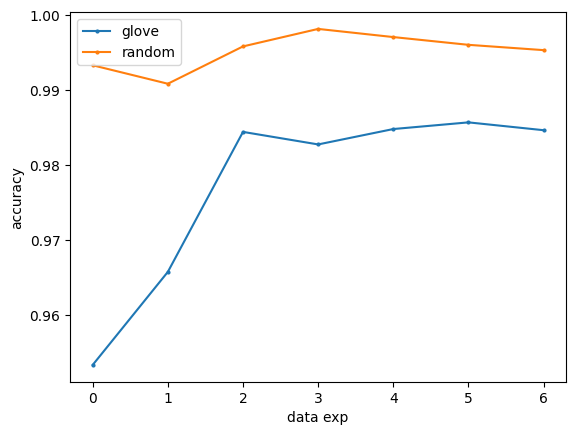

In [ ]:
# TEST 1.4
# DON'T DELETE THE OUTPUT
plot_numbers(best_valid_acc['glove'], label='glove', ylabel='accuracy', xlabel='data exp')
plot_numbers(best_valid_acc['random'], label='random', ylabel='accuracy', xlabel='data exp')

## Q1.4b [2pt] Conclusion

Based on the plots of the best accuracy scores on the validation part, how would you compare the use of randomized embeddings to the use of pre-trained embeddings?

<font color="red">█████ YOUR ANSWER HERE █████</font>

In general, pre-trained embeddings typically are outperformed by random embeddings. However, it can be observed that the performance gap narrows as the amount of data increases. This suggests the existence of a data volume at which both models might perform equivalently. Nonetheless, we can infer that both performances are really accurate as the best validation accuracy is above 96% in every case, specially for the random embedding that obtains an accuracy of almost 99% in several data experiments. On the other hand, the pre-trained embedding experiments an accuracy increasing as the data size increase.

# Part 2: Word sense disambiguation

In this part we will use the BERT transformer model's contextualized word embeddings to tackle the word sense disambiguation (WSD) task. The approach consists of the following:

1. Get the contextualized BERT embeddings for all tokens in a sense-annotated corpus;
2. For each sense $s$, calculate a mean vector of all the vectors of the words that are tagged with the sense $s$ in the training part of the corpus;
3. For each sense-annotated token $t$ in the test part of the corpus, assign $s$ sense to $t$ such that the vector of $s$ is the closest to the vector of $t$.
4. As a backup strategy for tokens in the test part for which no sense vector was obtained from the training part (i.e., tokens with unseen senses), use the 1st sense of the token by default.

## Setup

In [ ]:
# Course-specific package
! rm -rf assigntools
! git clone https://github.com/kovvalsky/assigntools.git
from assigntools.NLP.deep_learning import transformer_word2convec
from assigntools.M4LP.A1 import read_pickle, write_pickle

Cloning into 'assigntools'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 255 (delta 22), reused 0 (delta 0), pack-reused 200
Receiving objects: 100% (255/255), 62.92 KiB | 1.23 MiB/s, done.
Resolving deltas: 100% (124/124), done.


In [ ]:
import random, torch
import torch.nn.functional as F
from collections import defaultdict, Counter
from tqdm import tqdm
from tabulate import tabulate
import nltk
from more_itertools import chunked
from nltk.corpus import wordnet as wn
from nltk.corpus import semcor
from nltk.corpus.reader.wordnet import Lemma
nltk.download('semcor')
nltk.download('wordnet')

# append any imports if needed

[nltk_data] Downloading package semcor to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## SemCor

As a sense annotated corpus, we will use SemCor, conveniently available within NLTK. <code>semcor.sents()</code> iterates over all sentences represented as lists of tokens, while <code>semcor.tagged_sents()</code> iterates over the same sentences with additional annotation including WordNet Lemma identifiers (Lemma in WordNet stands for a particular sense of a word as opposed to a synset that is a set of Lemmas).

In [ ]:
# two sample sentence from the semcor corpus
# with their corresponding sense-annotated versions
for i in [0, 27]:
    print(semcor.sents()[i])
    print(semcor.tagged_sents(tag="sem")[i])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', 'Atlanta', "'s", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
[['The'], Tree(Lemma('group.n.01.group'), [Tree('NE', ['Fulton', 'County', 'Grand', 'Jury'])]), Tree(Lemma('state.v.01.say'), ['said']), Tree(Lemma('friday.n.01.Friday'), ['Friday']), ['an'], Tree(Lemma('probe.n.01.investigation'), ['investigation']), ['of'], Tree(Lemma('atlanta.n.01.Atlanta'), ['Atlanta']), ["'s"], Tree(Lemma('late.s.03.recent'), ['recent']), Tree(Lemma('primary.n.01.primary_election'), ['primary', 'election']), Tree(Lemma('produce.v.04.produce'), ['produced']), ['``'], ['no'], Tree(Lemma('evidence.n.01.evidence'), ['evidence']), ["''"], ['that'], ['any'], Tree(Lemma('abnormality.n.04.irregularity'), ['irregularities']), Tree(Lemma('happen.v.01.take_place'), ['took', 'place']), ['.']]
['His', 'petition', 'charged', 'mental', 'cruelty

Let's prepare SemCor data for the disambiguation task. Since this is just an educational exercise and we don't aim at replicating the full results, we can use only a subset of SemCor. Take the first $N$ sentences of SemCor, pre-process the data, shuffle the sample in the data **randomly**, and finally split the data into the training and test sets.

In [ ]:
# Extract a part of the data for experiments
N = 10_000
semcor_annotated = list(semcor.tagged_sents(tag='sem')[:N])
semcor_tokenized = list(semcor.sents()[:N])
random.Random(42).shuffle(semcor_annotated)
random.Random(42).shuffle(semcor_tokenized)

## Ex2.1 [9pt] Preprocessing data

Create a function that takes as input a collection of sense-annotated sentences from SemCor and extracts the sense annotation. For each token of the sentence get either the corresponding WordNet sense or <code>None</code>.
<code>None</code> corresponds to tokens that are: (1) not annotated with a Lemma object sense (e.g. articles); (2) representing a part of a larger phrase that is annotated with a sense. The latter represents a simplification of the task.  
More info about NLTK's Lemma and Tree objects can be found here: [Lemma](https://www.nltk.org/api/nltk.corpus.reader.wordnet.html) and [Tree](https://www.nltk.org/api/nltk.tree.tree.html).

In [ ]:
def get_sns_annotations(data):
    """ data - sense tagged data from semcor
        return
            the sense annotations as a list of lists.
            The structure follows to semcor sentences and tokenization
            The elements of the list are None or a tuple of strings
            representing a synset and a lemma.
            None annotation means that a word token has no sense annotation
    """
    ### YOUR CODE HERE ###
    extracted_data = []

    for semcor_sentence in data:
      extracted_sentence = []
      for token in semcor_sentence:
        if isinstance(token, nltk.tree.tree.Tree):
          if len(token.leaves())>1 or isinstance(token.label(), str) or token.height() > 2:
              extracted_sentence += [None] * len(token.leaves())

          else:
            label = token.label()
            synset = label.synset().name()
            name = label.name()

            extracted_sentence.append((synset, name))

        else:
          extracted_sentence += [None] * len(token)


      extracted_data.append(extracted_sentence)

    return extracted_data

In [ ]:
# TEST Ex2.1
semcor_senses = get_sns_annotations(semcor_annotated)

print("sample sentence:", semcor_tokenized[0])
print("sample annotation:", semcor_senses[0])

print("sample sentence:", semcor_tokenized[13])
print("sample annotation:", semcor_senses[13])

print("Total number of senses in the data =", len([ t for s in semcor_senses for t in s if t ]))

# test that for all sentences token number and annotation length are the same
for i, (senses, tokenized) in enumerate(zip(semcor_senses, semcor_tokenized, strict=True)):
    assert len(senses) == len(tokenized), \
        f"mismatch for {i}th sentence\n{senses}\n{tokenized}\n{semcor_annotated[i]}"

sample sentence: ['The', 'bronchial', 'artery', ',', 'except', 'for', 'a', 'small', 'number', 'of', 'short', 'branches', 'in', 'the', 'hilum', ',', 'contributes', 'none', 'of', 'the', 'pleural', 'blood', 'supply', '.']
sample annotation: [None, None, None, None, None, None, None, ('small.a.01', 'small'), ('number.n.02', 'number'), None, ('short.a.02', 'short'), ('branch.n.03', 'branch'), None, None, ('hilus.n.01', 'hilum'), None, ('contribute.v.02', 'contribute'), None, None, None, ('pleural.a.01', 'pleural'), ('blood.n.01', 'blood'), ('supply.n.01', 'supply'), None]
sample sentence: ['It', 'just', 'did', "n't", 'occur', 'to', 'Trig', 'that', 'anything', 'serious', 'would', 'happen', 'to', 'him', '.']
sample annotation: [None, ('merely.r.01', 'just'), None, None, ('occur.v.02', 'occur'), None, None, None, None, ('dangerous.s.02', 'serious'), None, ('happen.v.02', 'happen'), None, None, None]
Total number of senses in the data = 84296


Reference output:
```
sample sentence: ['The', 'bronchial', 'artery', ',', 'except', 'for', 'a', 'small', 'number', 'of', 'short', 'branches', 'in', 'the', 'hilum', ',', 'contributes', 'none', 'of', 'the', 'pleural', 'blood', 'supply', '.']
sample annotation: [None, None, None, None, None, None, None, ('small.a.01', 'small'), ('number.n.02', 'number'), None, ('short.a.02', 'short'), ('branch.n.03', 'branch'), None, None, ('hilus.n.01', 'hilum'), None, ('contribute.v.02', 'contribute'), None, None, None, ('pleural.a.01', 'pleural'), ('blood.n.01', 'blood'), ('supply.n.01', 'supply'), None]
sample sentence: ['It', 'just', 'did', "n't", 'occur', 'to', 'Trig', 'that', 'anything', 'serious', 'would', 'happen', 'to', 'him', '.']
sample annotation: [None, ('merely.r.01', 'just'), None, None, ('occur.v.02', 'occur'), None, None, None, None, ('dangerous.s.02', 'serious'), None, ('happen.v.02', 'happen'), None, None, None]
Total number of senses in the data = 84296
```

In [ ]:
# Run the following to get a reference data for comparison
# If your data differs from the reference, use the reference data in the subsequent parts
# !rm -f semcor_senses.pkl
# !wget -nv https://naturallogic.pro/_files_/download/mNLP/semcor_senses.pkl
# semcor_senses = read_pickle("semcor_senses.pkl")

In [ ]:
# create training and test sets
train_N = 9_000
semcor_X = {'train':semcor_tokenized[:train_N], 'test':semcor_tokenized[train_N:]}
semcor_Y = {'train':semcor_senses[:train_N], 'test':semcor_senses[train_N:]}

## BERT's contextualized vectors

After we have the training and test sets prepared with their gold sense annotations, it is time to get sense vectors for those senses that are occurring in the training set. Note that **contextualized vectors are crucial for the task** as a word (e.g., "book", "plant", "figure") can have different senses in different contexts.

We will use BERT transformer model to get contextualized word vectors for the words in the training and test sets. We will use the implementation of BERT in pytorch from the [transformers library](https://huggingface.co/docs/transformers/index).

Getting word vectors from BERT is not trivial as it uses a different type of tokenization than the traditional one. For example, the base-uncased version of BERT expects `Jupyter` tokenized as `ju`, `##py`, `##ter` while `Notebook` as `notebook` (note the lower casing of tokens due to the uncased version of BERT). To distinguish these two versions of tokenization and tokens, we will use `tokens` for BERT tokens and words for traditional tokenization. For example, the SemCor sentences use traditional tokenization.

If you want to learn more about BERT, [this](http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/) represents a gentle intro to BERT's wordpiece-based tokenizatio and contextualized word vectors.

In [ ]:
# if this cell errors with "A UTF-8 locale is required. Got ANSI_X3.4-1968"
# uncomment and run the next two lines
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# install transformer library
# !pip install transformers

In [ ]:
import transformers
from transformers import BertModel, AutoTokenizer
print(transformers.__version__) # 4.41.0

4.41.2


In [ ]:
# Load tokenizer (vocabulary)
MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# As usual, tokens are mapped to indices
print("The size of the token vocabulary", len(tokenizer.vocab))
for tok in ("dog", "##tion"):
    print(f"'{tok}' has index {tokenizer.vocab[tok]}")

for i in (3899, 3508):
    print(f"Reverse mapping: {i} --> {tokenizer.convert_ids_to_tokens(i)}")

The size of the token vocabulary 30522
'dog' has index 3899
'##tion' has index 3508
Reverse mapping: 3899 --> dog
Reverse mapping: 3508 --> ##tion


In [ ]:
example_input = "Transformers in Jupyter Notebook"
tok_result = tokenizer(example_input)
print("Output of a tokenizer: ", tok_result)
print("Tokens as word pieces: ", tokenizer.convert_ids_to_tokens(tok_result.input_ids))

Output of a tokenizer:  {'input_ids': [101, 19081, 1999, 18414, 7685, 3334, 14960, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
Tokens as word pieces:  ['[CLS]', 'transformers', 'in', 'ju', '##py', '##ter', 'notebook', '[SEP]']


`[CLS]` and `[SEP]` are special tokens use by BERT. `[CLS]` gets a vector that models the meaning of the entire input text sequence while `[SEP]` indicates sequence delimiters. Note that one of the tasks BERT was pre-trained on was guessing the next sentence, hence it was trained on sequence modeling, where elements of the sequence are sentences. Note that the output of `tokenizer([S1, S2])` and `tokenizer(S1, S2)` differ as in the first case the input is interpreted as a batch of two independent texts while in the second it is a sequence of texts.

The output of the tokenizer provides a sufficient input for BERT to process the input and assign contextualized embeddings.

In [ ]:
# Load pre-trained model (weights)
bert = BertModel.from_pretrained(MODEL_NAME)

#print parameters
bert.parameters

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<bound method Module.parameters of BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): BertOutput(
          (dense): Linear(in_features=3072, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (pooler): BertPooler(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
  )
)>

In [ ]:
# let bert output hidden states
bert.config.output_hidden_states = True
# bert expects tensors as an input
tok_result = tokenizer(example_input, return_tensors='pt')
bert_output = bert(**tok_result)
print("Dimension of the last (12th) hidden states (batch size X token number X vector dim): ", bert_output.hidden_states[-1].shape)

Dimension of the last (12th) hidden states (batch size X token number X vector dim):  torch.Size([1, 8, 768])


Due to non-trivial correspondence between BERT tokens and words, we provide you with a ready function that takes a batch/list of word-tokenized sentences and processes them with the BERT model. In the end, it returns contextualized word vectors for each input word. The vector of the words that consist of several tokens is obtained by collating token vectors (e.g., taking the mean by default). The function allows to indicate from which layer the vectors should be extracted. For more details you can read the function definition [here](https://github.com/kovvalsky/assigntools/blob/main/NLP/deep_learning.py).

In [ ]:
# Batches with GPU accelerates the process ~30 times when used T4 GPU of colab compared to CPU
# Obviously for this toy example, efficiency doesn't matter
# this identifies whether GPU is present
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("we are using", device)

sample_batch = [ "Transformers in Jupyter Notebook".split(), "Transformers visited the earth".split() ]
sample_output = transformer_word2convec(bert, tokenizer, sample_batch, device=device, collate_tok_vec=torch.mean, layer=-1)

# illustrating the output
for sent in sample_output:
    for w in sent:
        print(f"'{w['word']}' tokenized as {w['tokens']} with tensor (first 3 components) {w['pt'][:3]}")
    print()

# Comparing vectors of two occurrences of "Transformers"
tvec1, tvec2 = sample_output[0][0]['pt'], sample_output[1][0]['pt']
print(f"{tvec1[:5]}... != {tvec2[:5]}...")
print(f"vectors cosine similarity = {F.cosine_similarity(tvec1, tvec2, dim=0)}")

we are using cuda
'Transformers' tokenized as ['transformers'] with tensor (first 3 components) tensor([-0.2651, -0.0888, -0.1850])
'in' tokenized as ['in'] with tensor (first 3 components) tensor([ 0.8255,  0.1081, -0.4694])
'Jupyter' tokenized as ['ju', '##py', '##ter'] with tensor (first 3 components) tensor([-0.1719, -0.5191,  0.3761])
'Notebook' tokenized as ['notebook'] with tensor (first 3 components) tensor([-0.2273, -0.4334,  0.7509])

'Transformers' tokenized as ['transformers'] with tensor (first 3 components) tensor([-0.4967,  0.0918, -0.0243])
'visited' tokenized as ['visited'] with tensor (first 3 components) tensor([ 1.2033, -0.1839, -0.5399])
'the' tokenized as ['the'] with tensor (first 3 components) tensor([-0.8393,  0.1038,  0.2743])
'earth' tokenized as ['earth'] with tensor (first 3 components) tensor([-0.8355, -0.2884, -0.1953])

tensor([-0.2651, -0.0888, -0.1850,  0.4485,  0.1538])... != tensor([-0.4967,  0.0918, -0.0243,  0.1993, -0.2419])...
vectors cosine simi

## Ex2.2 [10pt] Sense vectors

Process the training set with BERT using `transformer_word2convec` with default parameters. After getting word vectors, iterate over all train sentences, and for each sense, collect the word vectors. Note that words without sense annotations will be ignored in this process.

Since senses in the same WordNet synset are considered equivalent, we will be using synsets as sense labels. Prepare a dictionary with synset `(synset_str)` as a key and a single tensor as a value. The tensor should be a mean of all the word vectors collected for the sense (this is a default collating method used by `transformer_word2convec`).

This process is a time-consuming part of this assignment. It is recommended to use Colab's GPU: max 5min of T4 GPU will suffice to process all sentences with BERT. While processing the sentences, use batches of size 64 (Hint: `chunked` from `more_itertools` can do batching for you). Note that batches make a big difference with GPU. For the purposes of developing and debugging your solution, you may start by using a sample of 100 sentences, but then switch to the full training set.

In [ ]:
# you can reuse global vars bert and tokenizer
def get_sense2vec(data_X, data_Y, batch_size=64, device=device, collate=torch.mean):
    """ data_X and data_Y are a list of tokenized semcor sentences with their corresponding sense annotations.
        The last two arguments are the same as in transformer_word2convec
        Returns 2 dictionaries:
            Sense2VecList - { synset_str -> list of tensors  }
            Sense2AvgVec - { synset_str -> a mean tensor  }
    """
    ### YOUR CODE HERE ###
    # sample_batch = [ "Transformers in Jupyter Notebook".split(), "Transformers visited the earth".split() ]
    #sample_output = transformer_word2convec(bert, tokenizer, sample_batch, device=device, collate_tok_vec=torch.mean, layer=-1)
    sense2vec = {}
    sense2veclist = {}
    from tqdm import tqdm

    for s_i, sentence_annotations in enumerate(data_Y):
      for t_i, ann in enumerate(sentence_annotations):
        if ann is None:
          continue
        else:
          synset_str = ann[0]
          sense2veclist[synset_str] = []

    batches_X = list(chunked(data_X, batch_size))
    batches_Y = list(chunked(data_Y, batch_size))

    for batch_i, batch in enumerate(tqdm(batches_X)):
      bert_output = transformer_word2convec(bert, tokenizer, batch, device=device, collate_tok_vec=torch.mean, layer=-1)
      for s_i, sentence in enumerate(bert_output):
        for w_i, word_output in enumerate(sentence):
          if batches_Y[batch_i][s_i][w_i] is None:
            continue
          else:
            synset_str = batches_Y[batch_i][s_i][w_i][0]
            sense2veclist[synset_str].append(word_output["pt"])
            #print(f"{synset_str=}\t{word_output['pt']}")

    for synset_str in sense2veclist:
      if sense2veclist[synset_str] == []:
        continue
      sense2vec[synset_str] = collate(torch.stack(sense2veclist[synset_str]), dim=0)

    return sense2vec, sense2veclist

In [ ]:
BATCH_SIZE = 64

Sense2AvgVec, Sense2VecList = get_sense2vec(semcor_X['train'], semcor_Y['train'], batch_size=BATCH_SIZE)

100%|██████████| 141/141 [01:10<00:00,  1.99it/s]


In [ ]:
# If you want to use reference vectors for next exercises, run the following:
# !rm -f Sense2AvgVec.pkl
# !wget -nv https://naturallogic.pro/_files_/download/mNLP/Sense2AvgVec.pkl
# Sense2AvgVec = read_pickle("Sense2AvgVec.pkl")

In [ ]:
# TEST Ex2.2
for sns in [ 'mature.v.01', 'promptly.r.01', 'state.v.01', 'be.v.01']:
    assert isinstance(Sense2VecList[sns], list)
    assert isinstance(Sense2VecList[sns][0], torch.Tensor)
    assert isinstance(Sense2AvgVec[sns], torch.Tensor)
    print(f"{sns} sense has {len(Sense2VecList[sns])} vectors with the mean vector = {Sense2AvgVec[sns][:8]} ...")

mature.v.01 sense has 3 vectors with the mean vector = tensor([ 0.0587,  0.0471, -0.4079, -0.1624,  0.2848,  0.0910,  0.6782,  0.3704]) ...
promptly.r.01 sense has 6 vectors with the mean vector = tensor([-0.2618,  0.0485,  0.1117,  0.0635,  0.5795, -0.1821,  0.0408,  1.0724]) ...
state.v.01 sense has 410 vectors with the mean vector = tensor([ 0.3054,  0.2383, -0.0089, -0.0291,  0.2214,  0.0783,  0.2360,  0.5706]) ...
be.v.01 sense has 2465 vectors with the mean vector = tensor([ 0.0400,  0.0864,  0.0222, -0.0710,  0.2275, -0.0252,  0.2669,  0.5936]) ...


Reference output
```
mature.v.01 sense has 3 vectors with the mean vector = tensor([ 0.0587,  0.0471, -0.4079, -0.1624,  0.2848,  0.0910,  0.6782,  0.3704]) ...
promptly.r.01 sense has 6 vectors with the mean vector = tensor([-0.2618,  0.0485,  0.1117,  0.0635,  0.5795, -0.1821,  0.0408,  1.0724]) ...
state.v.01 sense has 410 vectors with the mean vector = tensor([ 0.3054,  0.2383, -0.0089, -0.0291,  0.2214,  0.0783,  0.2360,  0.5706]) ...
be.v.01 sense has 2465 vectors with the mean vector = tensor([ 0.0400,  0.0864,  0.0222, -0.0710,  0.2275, -0.0252,  0.2669,  0.5936]) ...
```

## Ex2.3 [12pt] WSD testing

Now we are going to evaluate the sense embeddings on the test set. Write a function that takes a list of tokenized sentences and a mask that indicates which words are supposed to get senses. The function should return the sense predictions aligned with the sentences. When predicting a sense for a word token, use the strategy outlined above, with 1st WordNet sense as a fallback. Here is the strategy in more detail:

- Use the sense vectors that were calculated based on the training set;
- For each sense-annotated word token $t$ (e.g. the verb `run`) in the test set, predict the synset $s$ (e.g., `'run.x.xx'`) such that the vector of $s$ is the closest to the contextualized vector of $t$ based on the cosine distance metric. Also make sure that the predicted sense is applicable to a word token using [`wn.synsets()`](https://www.nltk.org/howto/wordnet.html).
- There will be word tokens $t$ in the test set for which there won't be a sense vector collected from the training set, i.e., unseen senses. For such word tokens, us a backup strategy and predict the 1st sense of the word from WordNet, which is the most common sense of the word. This can be done using a built-in function from NLTK (e.g. <code>wn.lemmas('run')[0]</code>). For more info about NLTK's WordNet API, check [this](https://www.nltk.org/howto/wordnet.html).

Note that the info that a word token has a gold sense unseen in the training set (provided by the mask argument), is not realistic info as it presupposes knowledge about gold annotations.

Below you are provided with the sense masking that indicates whether a word token gets a sense and whether its sense was seen in the training set.

In [ ]:
# masking of annotations: None - has NO sense annotation; True - has sense annotation and the sense
# was seen in the training set; False - has sense annotation but the sense was NOT seen in the training set
test_sense_mask = [ [ i if i is None else ( True if i[0] in Sense2AvgVec else False ) for i in s ] \
                        for s in semcor_Y['test'] ]

def wsd_accuracy(predictions, reference):
    """ Calculates accuracy with respect to the word tokens that get sense annotations.
    """
    true_and_false = [ p == r[0] for preds, refs in zip(predictions, reference, strict=True) \
                       for (p, r) in zip(preds, refs, strict=True) if r is not None ]
    return sum(true_and_false)/len(true_and_false)

In [ ]:
def predict_senses(sense2vec, sentences, sense_mask, fallback=False,
                   batch_size=BATCH_SIZE, bert=bert, tokenizer=tokenizer, device=device):
    """ sense2vec - a dictioanry from synset strings to torch tensor vectors
        sentences - a list of sentences each being a list of word tokens
        sense_mask - it is aligned with tokens of sentences and tells if a token gets sense
                    and what type sense, seen or unseen in the training set.
        fallback - if True it uses first sense as the option for tokens with unseen senses.
        batch_size - the number of sentences is a batch
        bert, tokenizer - bert model and a tokenizer compatible with it
        device - a cpu or a gpu/cuda device that will be used by bert and tensor computations
        return predictions
            a list of list of predictions (None or a synset as a string) where the structure
            is aligned with the sentences
    """

    batches_sentences = list(chunked(sentences, batch_size))
    batches_mask = list(chunked(sense_mask, batch_size))

    ### YOUR CODE HERE ###
    predictions = []

    for batch_i, sentence_batch in enumerate(tqdm(batches_sentences)):

      bert_output = transformer_word2convec(bert, tokenizer, sentence_batch, device=device, collate_tok_vec=torch.mean, layer=-1)

      for sentence_i, sentence in enumerate(sentence_batch):
        sentence_pred = []
        for token_i, token_mask in enumerate(batches_mask[batch_i][sentence_i]):
          token = sentence[token_i]

          # masking of annotations: None - has NO sense annotation; True - has sense annotation and the sense
          # was seen in the training set; False - has sense annotation but the sense was NOT seen in the training set
          if not token_mask:
            if fallback:
                # uses first sense as the option for tokens with unseen senses
                lemma = wn.lemmas(token)
                if lemma:
                  sentence_pred.append(lemma[0].synset().name())
                else:
                  sentence_pred.append(None)  # No sense available
            else:
              sentence_pred.append(None)

          else:
            synsets = wn.synsets(token)
            synsets = [synset.name() for synset in synsets]


            filtered_senses = [sense for sense in synsets if sense in list(sense2vec.keys())]

            if len(filtered_senses) == 0:
              if fallback:
                # uses first sense as the option for tokens with unseen senses
                lemma = wn.lemmas(token)
                if lemma:
                  sentence_pred.append(lemma[0].synset().name())
                else:
                  sentence_pred.append(None)  # No sense available
              else:
                sentence_pred.append(None)

            else:
              max_cosine_similarity = -1
              max_cosine_similarity_sense = None

              vectors = []
              for filtered_sense in filtered_senses:
                cosine_similarity = F.cosine_similarity(sense2vec[filtered_sense], bert_output[sentence_i][token_i]["pt"], dim=0).numpy()
                max_cosine_similarity = max(max_cosine_similarity, cosine_similarity)

                if max_cosine_similarity == cosine_similarity:
                  max_cosine_similarity_sense = filtered_sense

              # assert max_cosine_similarity_sense in synsets, f"{max_cosine_similarity_sense=} not in {synsets=}"
              sentence_pred.append(max_cosine_similarity_sense)


        predictions.append(sentence_pred)


    return predictions

In [ ]:
# TEST Ex2.3
# DON'T DELETE THE OUTPUT
# expected runtime less than a minute
predictions = predict_senses(Sense2AvgVec, semcor_X['test'], test_sense_mask)
predictions_fb = predict_senses(Sense2AvgVec, semcor_X['test'], test_sense_mask, fallback=True)

print("\nAccuracy of BERT      =", wsd_accuracy(predictions, semcor_Y['test']))
print("Accuracy of BERT + WN =", wsd_accuracy(predictions_fb, semcor_Y['test']))

100%|██████████| 16/16 [00:48<00:00,  3.04s/it]


Accuracy of BERT      = 0.6516674840608141
Accuracy of BERT + WN = 0.6935998038254046


Reference output (where `X<Y`):

```
Accuracy of BERT      = 0.6X...
Accuracy of BERT + WN = 0.6Y...
```

## Further experiments

Congratulations! You have reached the end of lab 4.

If you want an additional challenge, you can carry out further experiments on WSD task. Note that in the experiments we used the vectors from the last layer of BERT, but several research papers have shown that the vectors from different layers also encode useful information.

1.   You can test whether the vectors from other layers perform better than the last layer vectors.
2.   Word (and sense vectors) can be defined in terms of the combinations of the vectors from several layers of BERT. You can verify whether concatenating vectors from different layers (e.g., a concatenation of vectors from the last two layers) performs better than the vectors from the single layers.


# Acknowledgment

The initial assignment by Denis Paperno included the contrast of pretrained and random word embeddings on POS tagging (using the extended Penn Treebank POS tags) and replication of the WSD experiment for ELMo. The assignment was built around the allennlp library.

Since 2022-23 course, the assignment was substantially changed by Lasha Abzianidze. allennlp was replaced with pytorch and transformers library. ELMo was replaced with BERT and Penn Treebank POS tagging with Universal POS tagging. The first part now teaches students how to build a neural network tagger instead of using out-of-the-box tagger. These changes also drastically decreased GPU/CPU processing time.